In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, SpectralClustering
from sklearn import metrics

from sqlalchemy import create_engine
import datetime 
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
import matplotlib.cm as cm
import matplotlib
from TurbineTimeSeries.storage import MachineDataStore
#from TurbineTimeSeries.transformations import PCA, StandardScaler, DropCols, DropSparseCols, LeftJoin

In [9]:
model_number = 2

store = MachineDataStore('.config')

# model_data_hr = (store.query(model_number,'1hr')
#                  .not_null(['timestamp','psn'])
# #                  .exclude_psn([44,52,54,70])
#                  .execute())

model_data_min = (store.query(model_number,'10min')
                  .not_null(['timestamp','psn'])
                  .exclude_psn([44,52,54,70])
                  .execute())

model_data_min.head()

id  lo_c_dp1   f_c_dp1   f_c_dp2   f_c_dp5  pe_c_dt1  g_c_dt1  g_c_dt2  \
0   1  0.378187  0.337323 -0.181580  0.283768  0.546667    0.352    0.398   
1   2  0.384455  0.304681 -0.062424  0.281090  0.578889    0.360    0.374   
2   3  0.395580  0.256122  0.017021  0.284209  0.567778    0.366    0.398   
3   4  0.388409  0.268359 -0.073769  0.282309  0.564444    0.352    0.372   
4   5  0.385170  0.269397 -0.175926  0.281459  0.567778    0.324    0.380   

   lo_c_dt5   c_dt5_1 ...     v_d_2b     lo_t5      g_t2    f_t1  \
0  0.444706 -0.021556 ...   0.167029  0.714348  0.836571  0.3800   
1  0.443529 -0.019334 ...   0.170886  0.713913  0.829714  0.3775   
2  0.444706 -0.022222 ...   0.162286  0.713043  0.834857  0.3770   
3  0.447059 -0.019722 ...   0.161743  0.713043  0.826286  0.3750   
4  0.447059 -0.020722 ...   0.165914  0.713913  0.829714  0.3760   

        sum_enr    g_t3   g_pct1    f_pos1                  timestamp  psn  
0  22452.305823  0.8516  0.10789  0.213541 2017-06-26 12:00:11.999995   39  
1  22452.415190  0.8472  0.11142  0.216346 2017-06-26 12:10:00.000004   39  
2  22452.642025  0.8476  0.11171  0.214744 2017-06-26 12:30:00.000003   39  
3  22452.753418  0.8620  0.10986  0.214342 2017-06-26 12:39:59.999997   39  
4  22452.866835  0.8788  0.10974  0.215144 2017-06-26 12:50:00.000002   39  

[5 rows x 76 columns]

In [10]:
freq = '10min'
model_data = model_data_min
len(model_data)

1602740

In [11]:
skipped_cols = ['sum_esn','sum_eng_st', 'sum_eng_h']
index_cols = ['id','timestamp','psn']
data_cols = [c for c in model_data.columns if (c not in index_cols) and (c not in skipped_cols)]

In [12]:
missing_values = model_data.isnull().sum().sort_values()
sparse_cols = [x for x in missing_values.index if missing_values[x] > 30000]
clean_data_cols = [x for x in data_cols if x not in sparse_cols]

In [13]:
data = model_data[index_cols + clean_data_cols].dropna().reset_index()
clean_data = StandardScaler().fit_transform(data[clean_data_cols])

pca =  PCA().fit(clean_data)
reduced = pca.transform(clean_data)

In [14]:
def roundTime(dt=None, roundTo=60):
    """Round a datetime object to any time laps in seconds
    dt : datetime.datetime object, default now.
    roundTo : Closest number of seconds to round to, default 1 minute.
    Author: Thierry Husson 2012 - Use it as you want but don't blame me.
    """
    if dt == None : dt = datetime.datetime.now()
    seconds = (dt.replace(tzinfo=None) - dt.min).seconds
    rounding = (seconds+roundTo/2) // roundTo * roundTo
    return dt + datetime.timedelta(0,rounding-seconds,-dt.microsecond)
n = datetime.datetime(2015,12,5,0,10,0,4)
print(n)
print(roundTime(n,600))

2015-12-05 00:10:00.000004
2015-12-05 00:10:00


In [15]:
eigenvectors_to_segment = 1
half_hour_segments = []
twelve_hour_segments = []
#def half_hour_group(x):
    #return str(x['iso'][0])+'-'+str(x['iso'][1])+'-'+str(x['iso'][2])+'-'+str(x['hour'])+'-'+('0' if x['minute'] < 30 else '1')
def twelve_hour_group(x):
    return str(x['iso'][0])+'-'+str(x['iso'][1])+'-'+str(x['iso'][2])+'-'+('0' if x['hour'] < 12 else '1')
for i in range(eigenvectors_to_segment):
    twelve_hour_segments.append([])
    
for psn in data['psn'].sort_values().unique():
    print(str(psn), datetime.datetime.now())
    psn_data = pd.DataFrame(data[(data['psn'] == psn)])
    psn_data['timestamp'] = psn_data['timestamp'].apply(lambda x: roundTime(datetime.datetime(x.year,x.month,x.day,x.hour,x.minute,x.second),600))
    psn_data['iso'] = psn_data['timestamp'].apply(lambda x: x.isocalendar())
    psn_data['hour'] = psn_data['timestamp'].apply(lambda x: x.time().hour)
    psn_data['minute'] = psn_data['timestamp'].apply(lambda x: x.time().minute)
    print('\t time parsing done', datetime.datetime.now())
    psn_data['twelve_hour_group'] = psn_data.apply(twelve_hour_group,1)
    complete_groups = (psn_data.groupby(by=['twelve_hour_group']).count()['id'] == 72)
    psn_data['complete_group'] = psn_data['twelve_hour_group'].apply(lambda x: complete_groups[x])
    psn_data = psn_data[psn_data['complete_group'] == True]
    print('\t block grouping done', datetime.datetime.now())
   
    for d in psn_data['twelve_hour_group'].unique():
        group_data = (psn_data[psn_data['twelve_hour_group'] == d]).sort_values(by='minute')
        idx = group_data.index
        
        for i in range(eigenvectors_to_segment):
            half_hour_segments[i].append([x for x in reduced[idx,i]])
    
    print('\t block aggregating done', datetime.datetime.now())
   
 

34 2018-04-28 14:52:39.760717
	 time parsing done 2018-04-28 14:52:42.254733
	 block grouping done 2018-04-28 14:52:56.194422
	 block aggregating done 2018-04-28 14:53:07.574890
35 2018-04-28 14:53:07.575035
	 time parsing done 2018-04-28 14:53:08.914760
	 block grouping done 2018-04-28 14:53:18.443467
	 block aggregating done 2018-04-28 14:53:23.051627
36 2018-04-28 14:53:23.051787
	 time parsing done 2018-04-28 14:53:24.335062
	 block grouping done 2018-04-28 14:53:33.926894
	 block aggregating done 2018-04-28 14:53:37.423674
37 2018-04-28 14:53:37.423879
	 time parsing done 2018-04-28 14:53:38.694855
	 block grouping done 2018-04-28 14:53:46.816823
	 block aggregating done 2018-04-28 14:53:52.862783
38 2018-04-28 14:53:52.862936
	 time parsing done 2018-04-28 14:53:53.412387
	 block grouping done 2018-04-28 14:53:57.044288
	 block aggregating done 2018-04-28 14:53:58.670172
39 2018-04-28 14:53:58.670336
	 time parsing done 2018-04-28 14:53:59.054322
	 block grouping done 2018-04-28 

In [ ]:
# for i in range(eigenvectors_to_segment):
#     twelve_hour_segments.append([])

# for psn in data['psn'].sort_values().unique():
#      print(str(psn), datetime.datetime.now())
#        psn_data = pd.DataFrame(data[(data['psn'] == psn)])
#        psn_data['timestamp'] = psn_data['timestamp'].apply(lambda x: roundTime(datetime.datetime(x.year,x.month,x.day,x.hour,x.minute,x.second),600))
#        psn_data['iso'] = psn_data['timestamp'].apply(lambda x: x.isocalendar())
#        psn_data['hour'] = psn_data['timestamp'].apply(lambda x: x.time().hour)
#        psn_data['minute'] = psn_data['timestamp'].apply(lambda x: x.time().minute)
#        print('\t time parsing done', datetime.datetime.now())
#        psn_data['twelve_hour_group'] = psn_data.apply(twelve_hour_group,1)
#        complete_groups = (psn_data.groupby(by=['twelve_hour_group']).count()['id'] == 72)
#        psn_data['complete_group'] = psn_data['twelve_hour_group'].apply(lambda x: complete_groups[x])
#        psn_data = psn_data[psn_data['complete_group'] == True]
#        print('\t block grouping done', datetime.datetime.now())
  
#    for d in psn_data['twelve_hour_group'].unique():
#        group_data = (psn_data[psn_data['twelve_hour_group'] == d]).sort_values(by='minute')
#        idx = group_data.index
       
#        for i in range(eigenvectors_to_segment):
#            twelve_hour_segments[i].append([x for x in reduced[idx,i]])
   
#    print('\t block aggregating done', datetime.datetime.now())

In [18]:
complete_groups

half_hour_group
2016-23-1-1    False
2016-23-2-0     True
2016-23-2-1    False
2016-25-4-1    False
2016-25-5-0     True
2016-25-5-1     True
2016-25-6-0     True
2016-25-6-1    False
2016-25-7-0     True
2016-25-7-1     True
2016-26-1-0     True
2016-26-1-1     True
2016-26-2-0     True
2016-26-2-1     True
2016-26-3-0     True
2016-26-3-1     True
2016-26-4-0     True
2016-26-4-1     True
2016-26-5-0     True
2016-26-5-1     True
2016-26-6-0     True
2016-26-6-1     True
2016-26-7-0     True
2016-26-7-1     True
2016-27-1-0     True
2016-27-1-1     True
2016-27-2-0     True
2016-27-2-1     True
2016-27-3-0     True
2016-27-3-1     True
               ...  
2017-47-3-1     True
2017-47-4-0     True
2017-47-4-1     True
2017-47-5-0     True
2017-47-5-1     True
2017-47-6-0     True
2017-47-6-1     True
2017-47-7-0     True
2017-47-7-1     True
2017-48-1-0     True
2017-48-1-1     True
2017-48-2-0     True
2017-48-2-1     True
2017-48-3-0     True
2017-48-3-1     True
2017-48-4-0     Tr

In [23]:
def plot_cluster_distribution():
    plt.rcParams["figure.figsize"] = (15,15)
    fig = plt.figure(0)
    ax1 = plt.subplot2grid((1,1), (0, 0))
    ax1.bar(range(n_clusters),label_counts[:])
    ax1.set_ylabel('Segment Count')
    ax1.set_xlabel('Cluster')
    plt.suptitle("Model {} Cluster Distributions for Eigenvector {}, 30 Minute Profiles".format(model_number, j+1))
    plt.grid("on")
    fig.savefig("model{}_kmeans_{}_eig{}_30_min_cluster_distribution.png".format(model_number, n_clusters,j+1))
       
    plt.show()
    
def plot_cluster_grid():
    plt.rcParams["figure.figsize"] = (15,15)
    plt.show()

    grid_size = (n_clusters,1)
    cluster_means = []

    fig = plt.figure(0)
    row = -1
    shared_ax = None

    for i,c in enumerate(labels_sorted_by_freq):
        cluster_data = [to_be_clustered[j] for j in range(len(cluster.labels_)) if cluster.labels_[j] == c]
        cluster_means.append(pd.DataFrame(cluster_data).mean())
        
        col = i%15
        row = row if col > 0 else row+1
        
        ax = plt.subplot2grid((15,15), (row,col),sharey=shared_ax)
        
        ax.plot(pd.DataFrame(cluster_data).T,alpha=0.2, color='red')
        plt.axis('off')
        
        if shared_ax is None:
            shared_ax = ax     

        
    plt.suptitle("Model {} Eigenvector {}, 12 Hour Profiles".format(model_number, j+1))  
    fig.savefig("model{}_kmeans_{}_eig{}_12_hr_cluster_grid.png".format(model_number, n_clusters,j+1))
    plt.show()
    plt.close()
    
def plot_clusters(c_idx):
    plt.rcParams["figure.figsize"] = (14, 7)
    for i, c in enumerate(c_idx):
        cluster_data = [to_be_clustered[j] for j in range(len(cluster.labels_)) if cluster.labels_[j] == c]
                
        fig = plt.figure(0)
        ax = plt.subplot2grid((1,1), (0,0))
        ax.plot(pd.DataFrame(cluster_data).T,alpha=0.2, color='red')
        ax.set_xlabel('Time of Day')
        plt.suptitle("Model {} Eigenvector {},12 Hour Cluster {} ".format(model_number, j+1, i+1))  
        fig.savefig("model{}_kmeans_{}_eig{}_12_hr_cluster{}.png".format(model_number, n_clusters,j+1, i+1))
        plt.show
        plt.close()
      

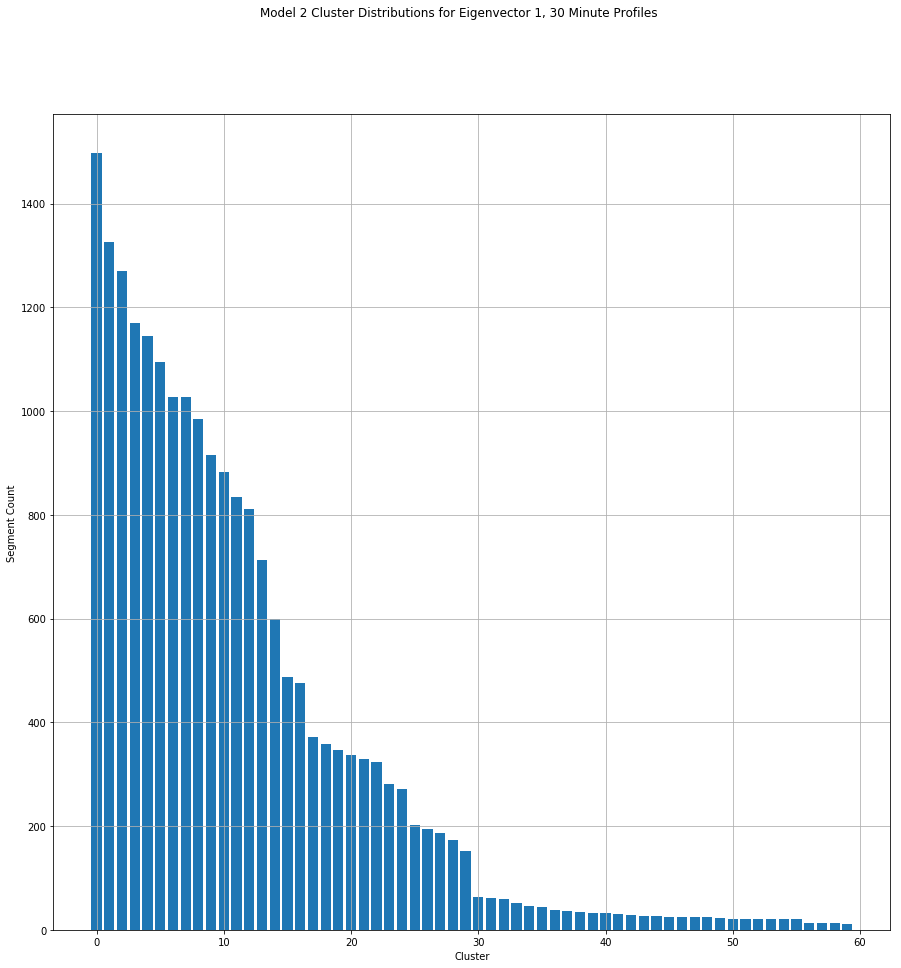

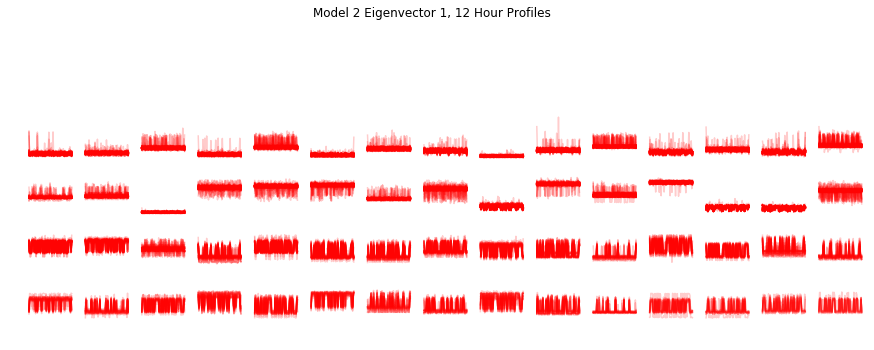

In [24]:
for j, daily_coefficients in enumerate(half_hour_segments):
    to_be_clustered = daily_coefficients
    n_clusters=60

    cluster = KMeans(n_clusters)
    cluster.fit(to_be_clustered)
    label_df = pd.DataFrame(cluster.labels_)
    label_counts = label_df[0].value_counts().sort_values(ascending=False)
    labels_sorted_by_freq = list(label_counts.keys())
    
    plot_cluster_distribution()
    plot_cluster_grid()
    if j == 0:
        plot_clusters(labels_sorted_by_freq)

In [48]:
reduced_df = pd.DataFrame(reduced)

In [49]:
reduced_
reduced_df['psn'] = data.psn.values
reduced_df['timestamp'] = data.timestamp.values

#reduced_df.set_index([data.psn.values, data.timestamp.values])

In [50]:
eig_df.columns = 'eig'

Index(['psn', 'timestamp', 0], dtype='object')

In [58]:
eig_df = reduced_df[['psn','timestamp',0]]
eig_df.columns = ['psn','timestamp','eig1']
eig_df.head()

psn                  timestamp      eig1
0   39 2017-06-26 12:00:11.999995 -4.410430
1   39 2017-06-26 12:10:00.000004 -4.435313
2   39 2017-06-26 12:30:00.000003 -4.532668
3   39 2017-06-26 12:39:59.999997 -4.436621
4   39 2017-06-26 12:50:00.000002 -4.410684

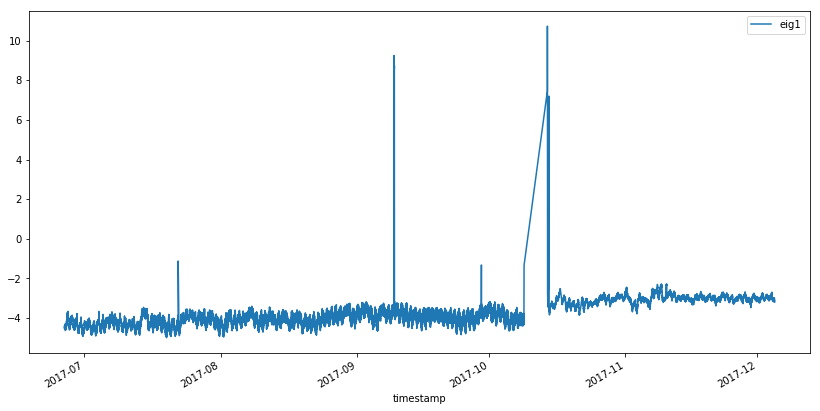

In [61]:
eig_df[eig_df.psn==39].plot(y='eig1', x = 'timestamp')
plt.show()

In [116]:
import numpy as np
import pylab

def thresholding_algo(y, lag=20, threshold=20, influence=0):
    """
    lag = the lag of the moving window, 
    threshold = the z-score at which the algorithm signals and 
    influence = the influence (between 0 and 1) of new signals on the mean and standard deviation.
    """
    signals = np.zeros(len(y))
    filteredY = np.array(y)
    avgFilter = [0]*len(y)
    stdFilter = [0]*len(y)
    avgFilter[lag - 1] = np.mean(y[0:lag])
    stdFilter[lag - 1] = np.std(y[0:lag])
    for i in range(lag, len(y)):
        if abs(y[i] - avgFilter[i-1]) > threshold * stdFilter [i-1]:
            if y[i] > avgFilter[i-1]:
                signals[i] = 1
            else:
                signals[i] = -1

            filteredY[i] = influence * y[i] + (1 - influence) * filteredY[i-1]
            avgFilter[i] = np.mean(filteredY[(i-lag):i])
            stdFilter[i] = np.std(filteredY[(i-lag):i])
        else:
            signals[i] = 0
            filteredY[i] = y[i]
            avgFilter[i] = np.mean(filteredY[(i-lag):i])
            stdFilter[i] = np.std(filteredY[(i-lag):i])

    return dict(signals = np.asarray(signals),
                avgFilter = np.asarray(avgFilter),
                stdFilter = np.asarray(stdFilter))

/Users/jillianjarrett/anaconda2/envs/py36envir/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/jillianjarrett/anaconda2/envs/py36envir/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


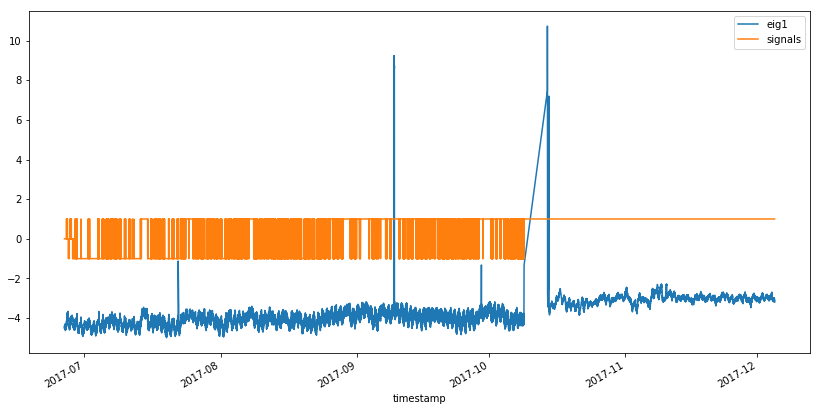

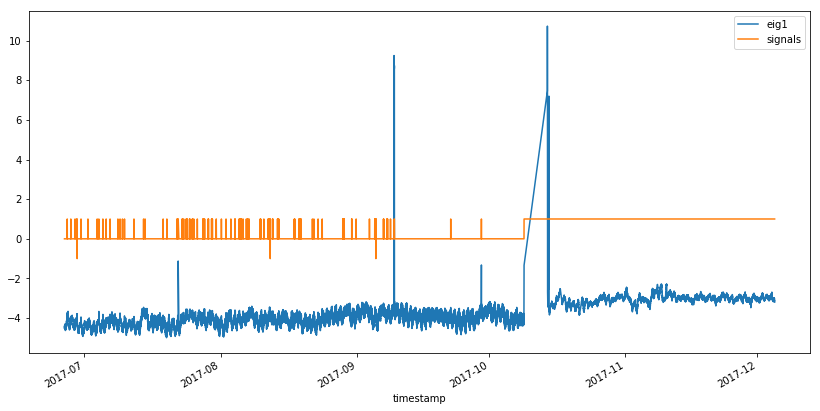

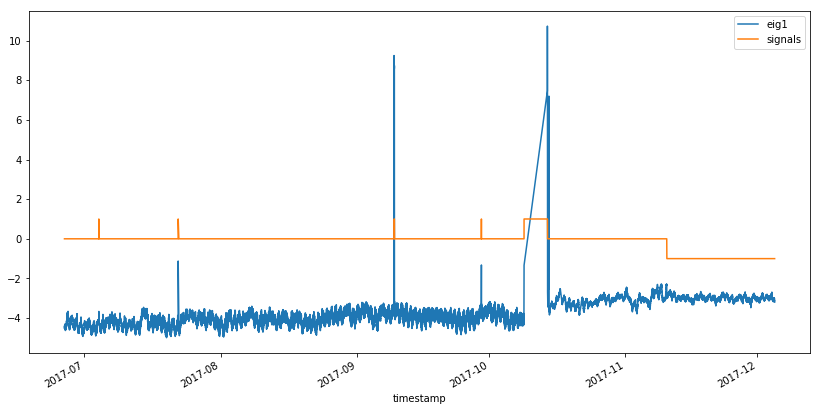

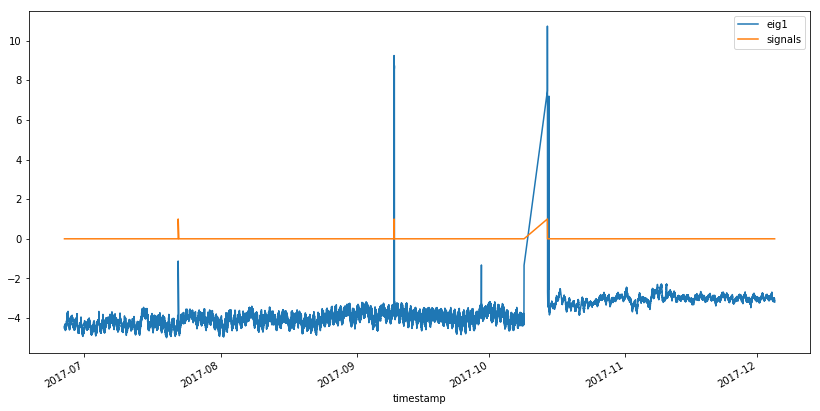

In [114]:
for i in [3,5,10,20]:    
    psn39_signals = thresholding_algo(eig_df[eig_df.psn==39].eig1.values, threshold=i)
    psn39 = eig_df[eig_df.psn==39]
    psn39['signals'] = psn39_signals['signals']
    psn39.plot(y=['eig1','signals'], x = 'timestamp')
    plt.show()

/Users/jillianjarrett/anaconda2/envs/py36envir/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/jillianjarrett/anaconda2/envs/py36envir/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


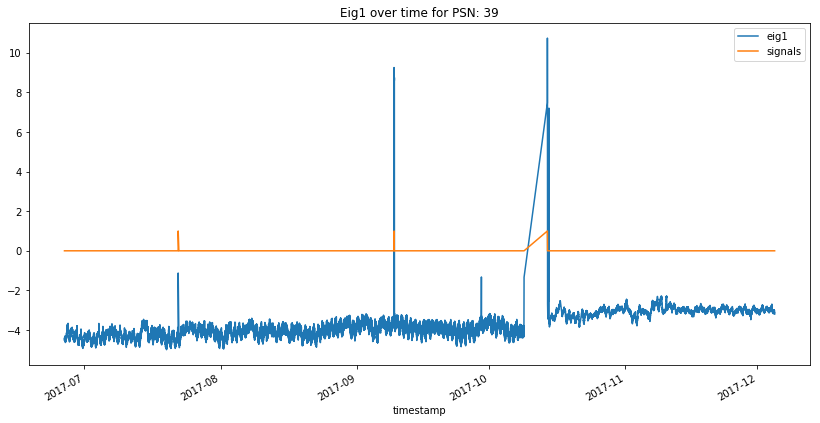

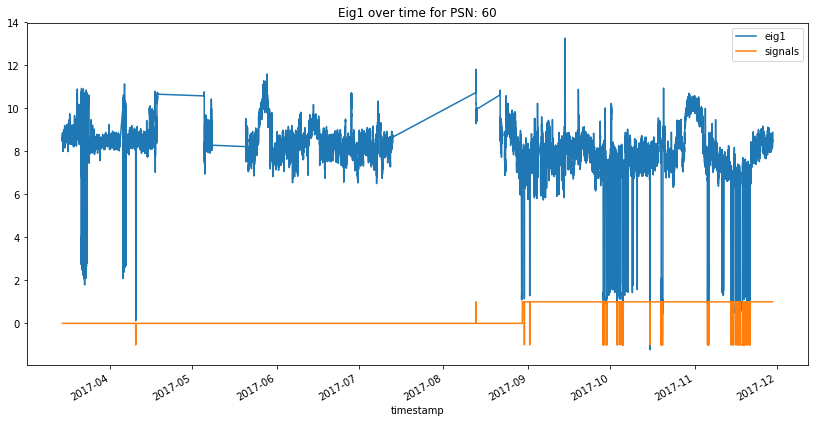

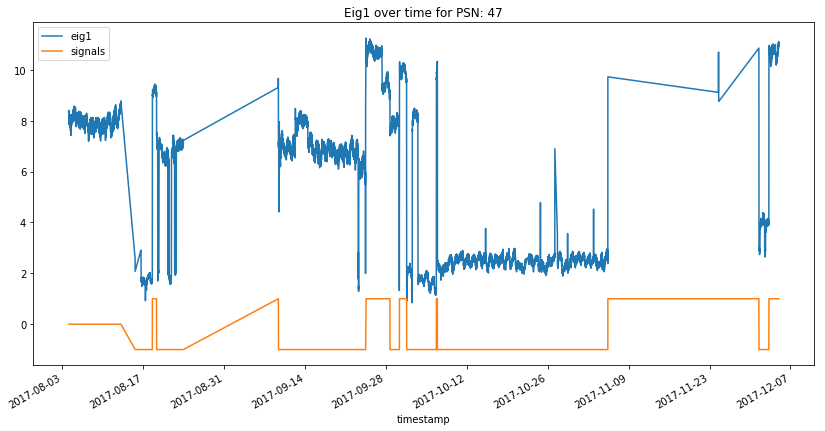

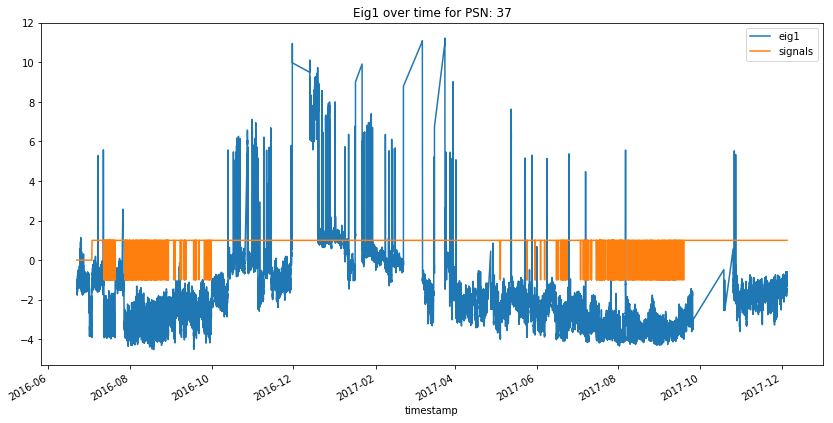

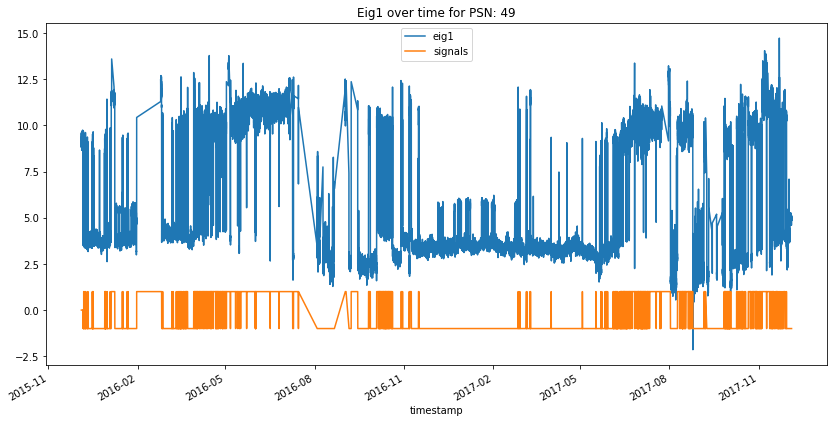

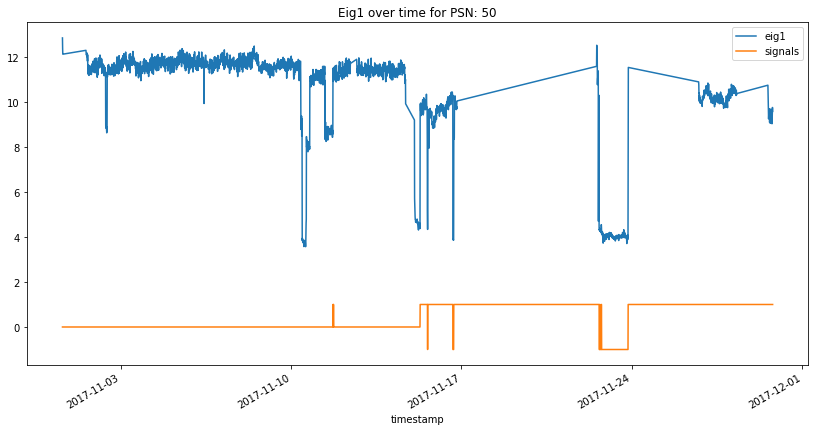

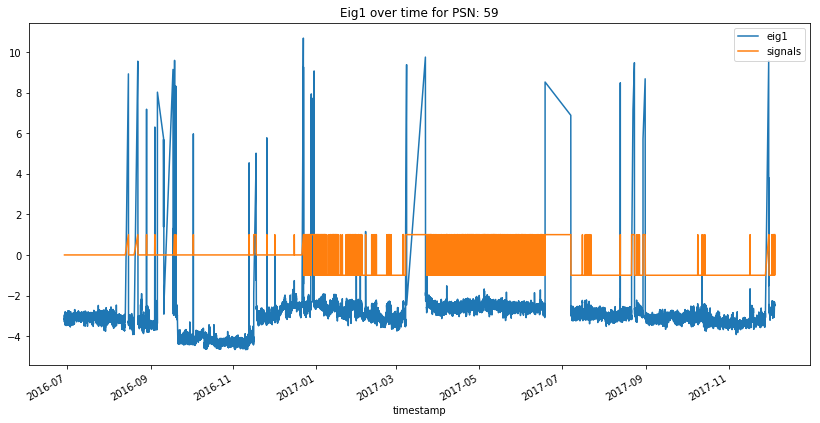

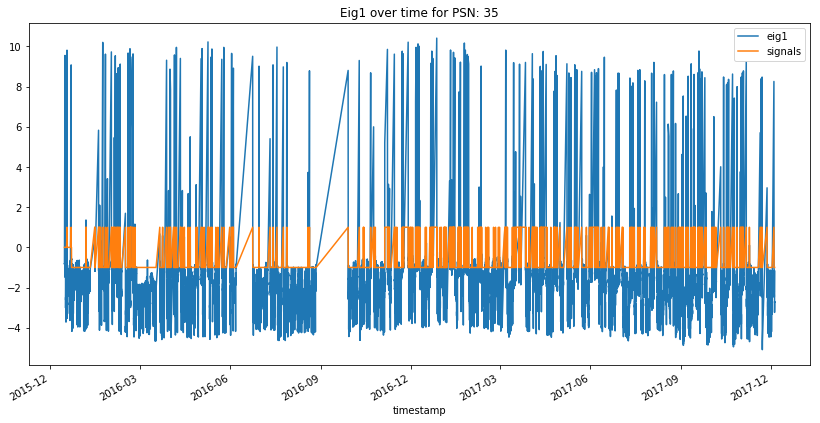

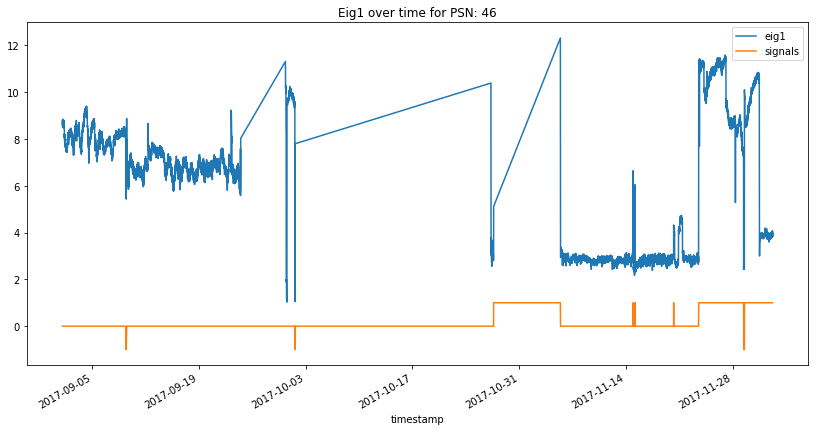

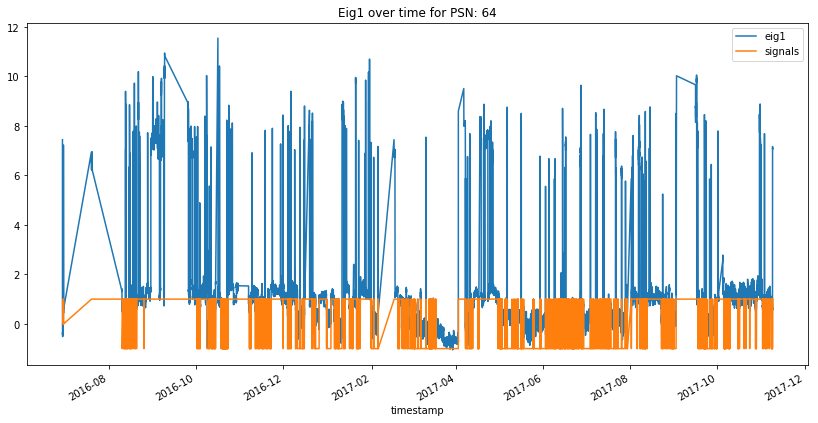

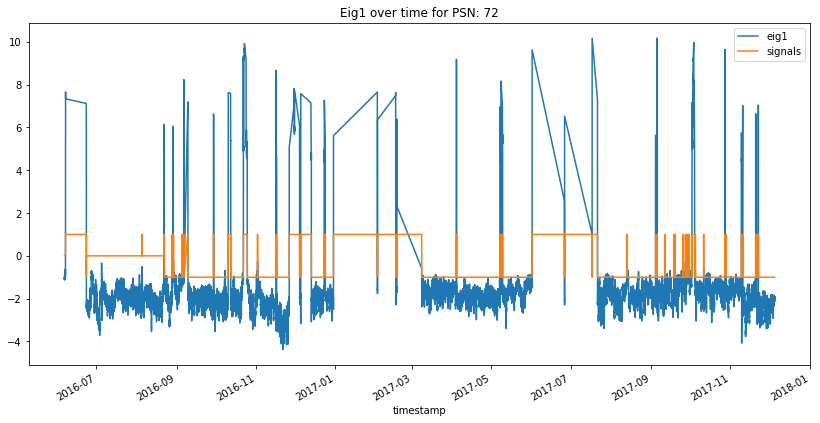

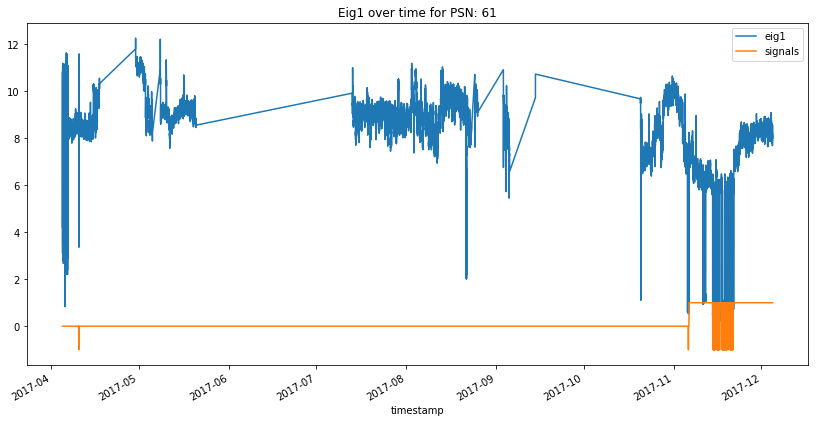

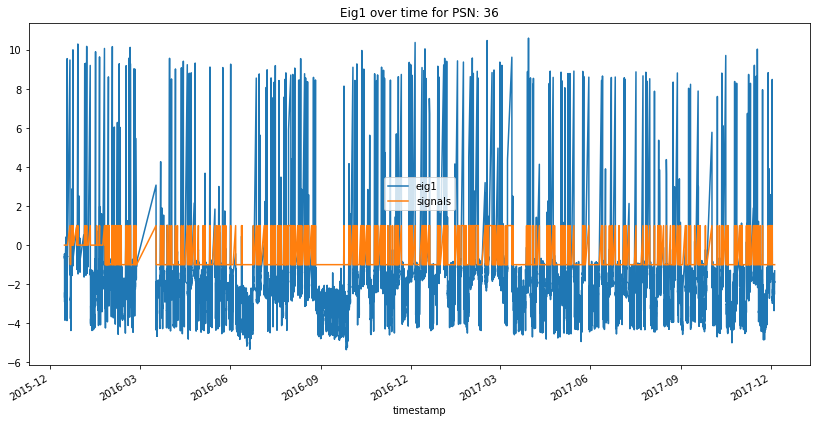

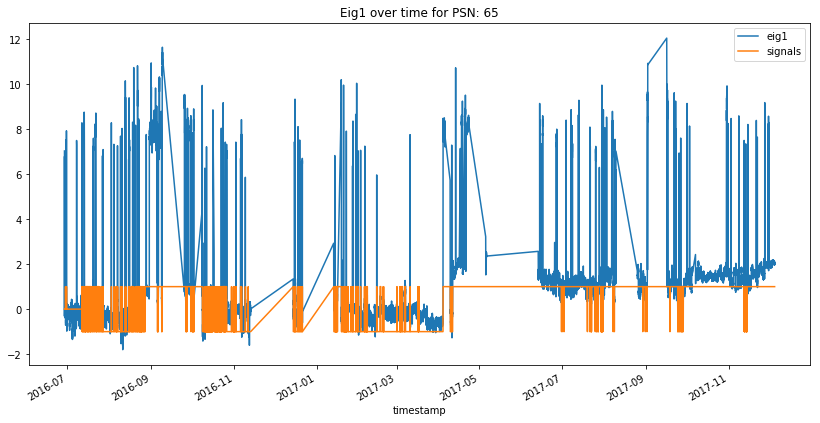

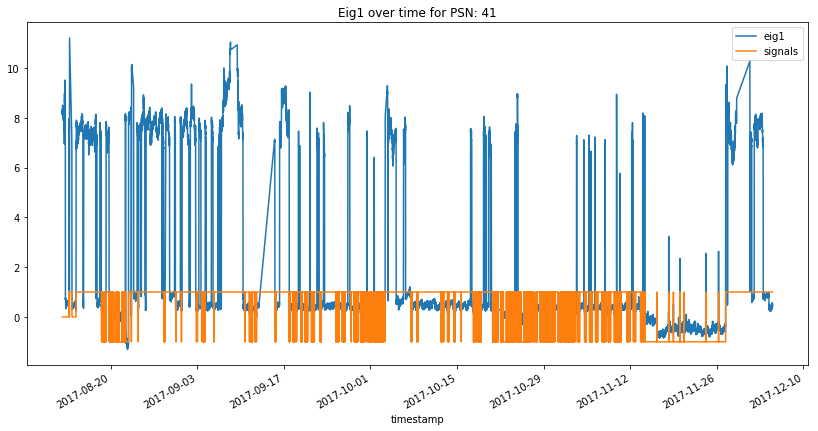

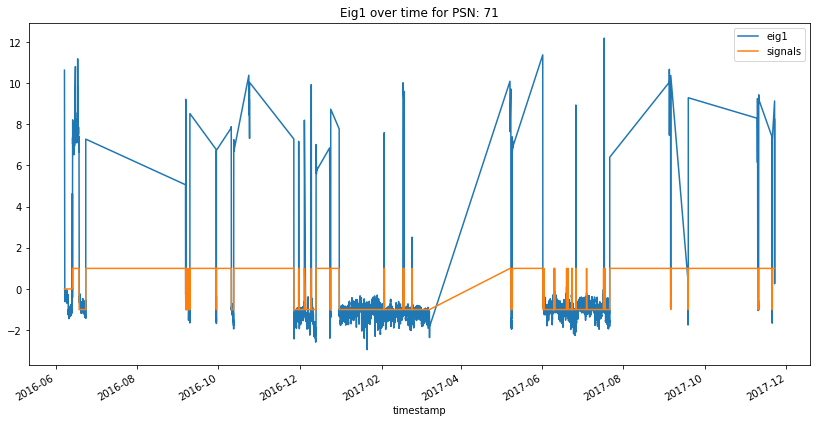

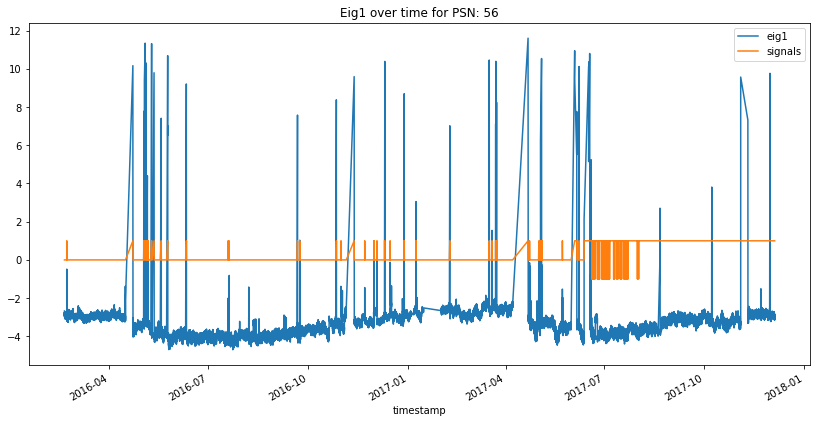

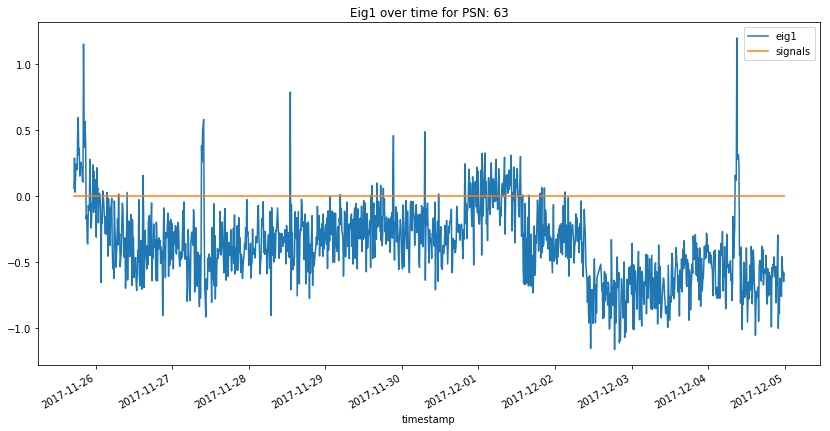

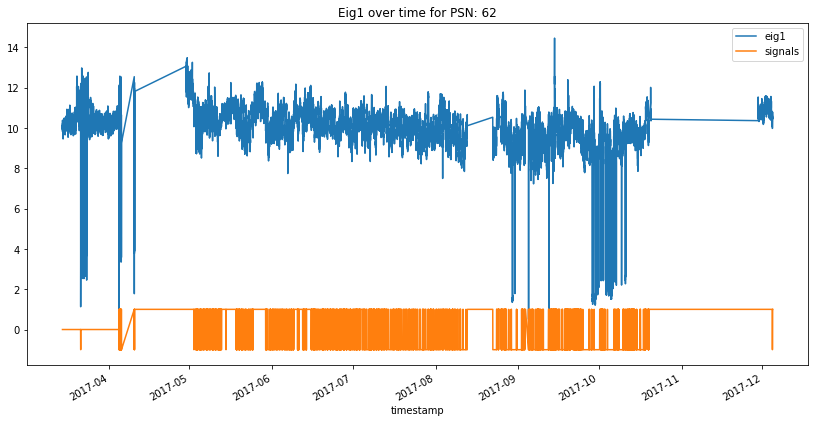

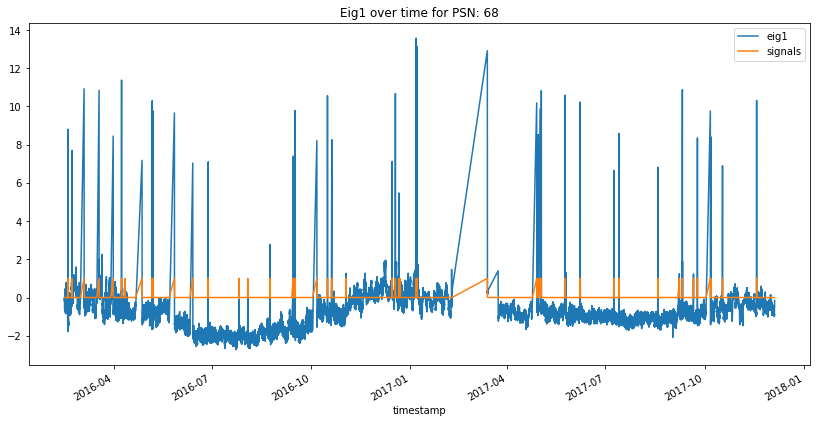

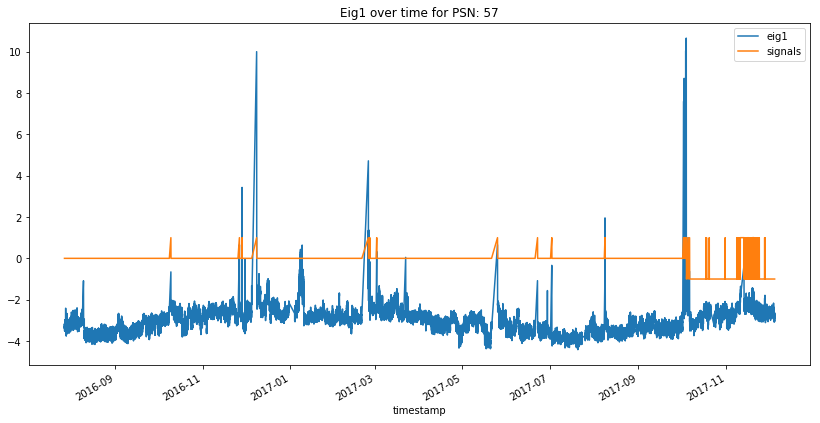

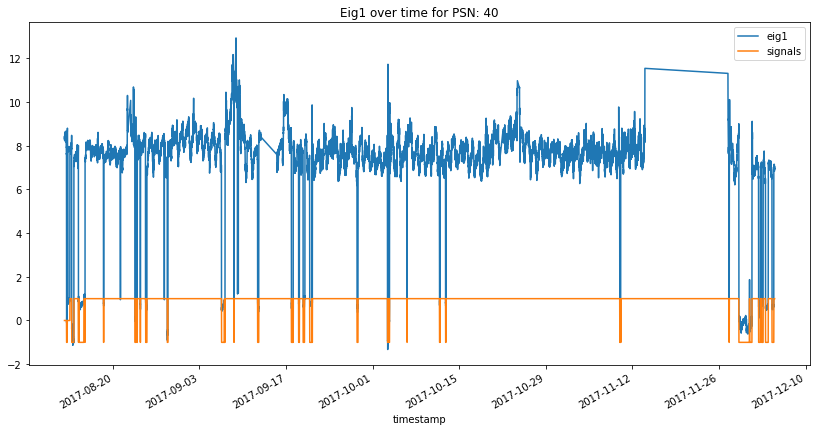

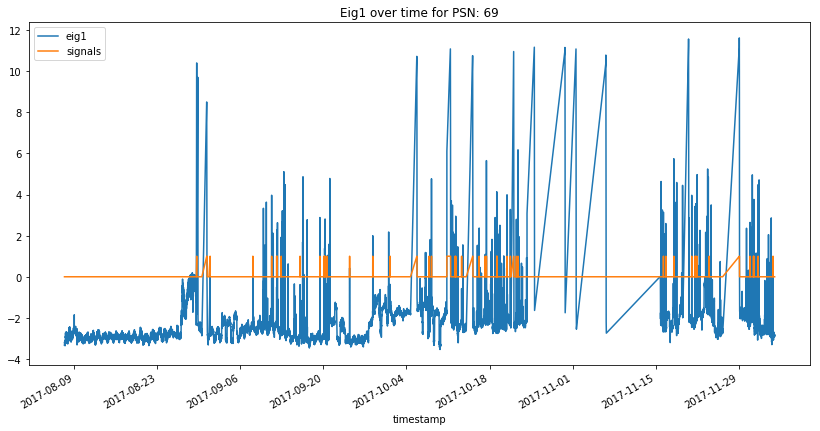

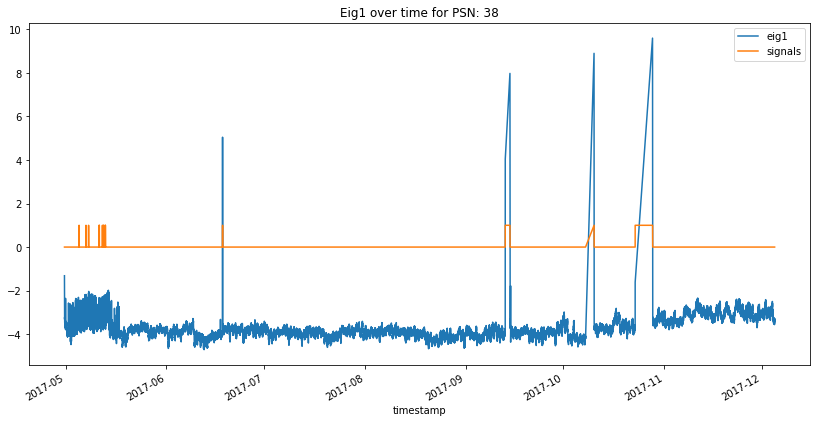

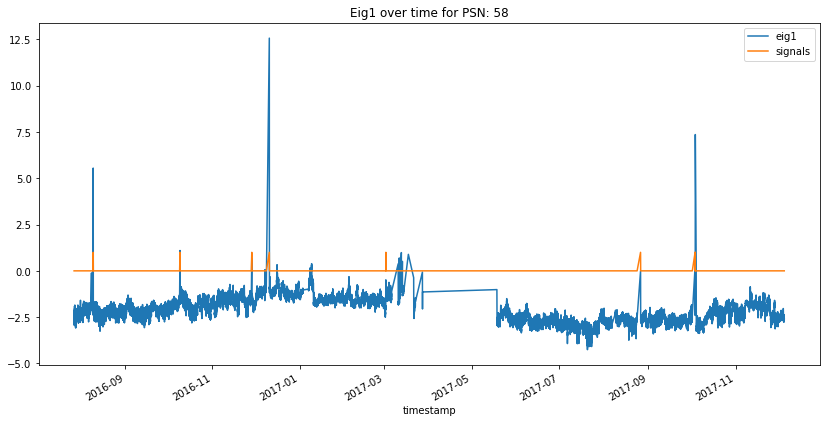

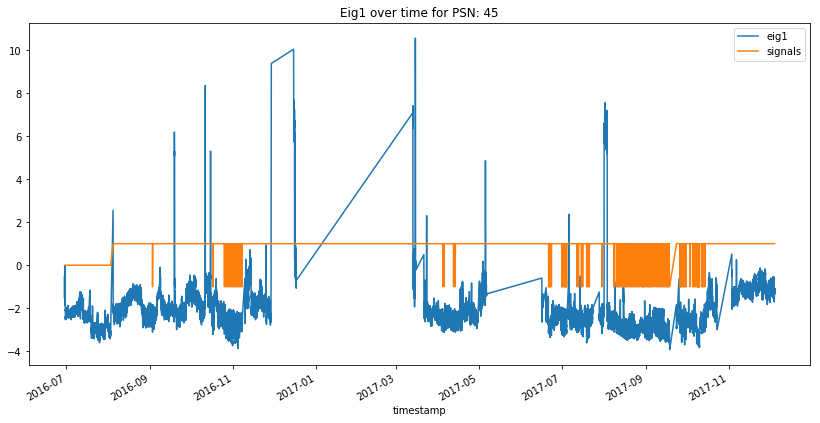

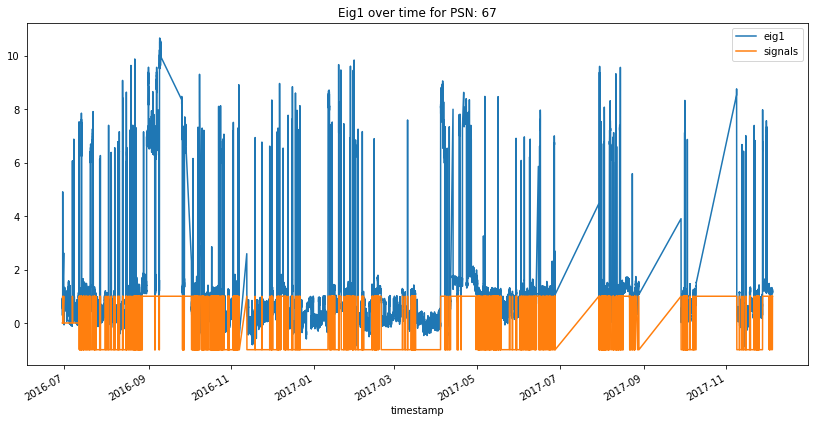

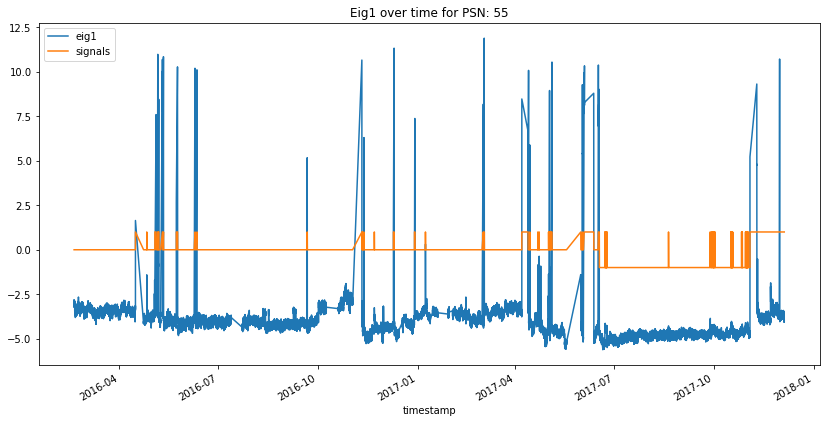

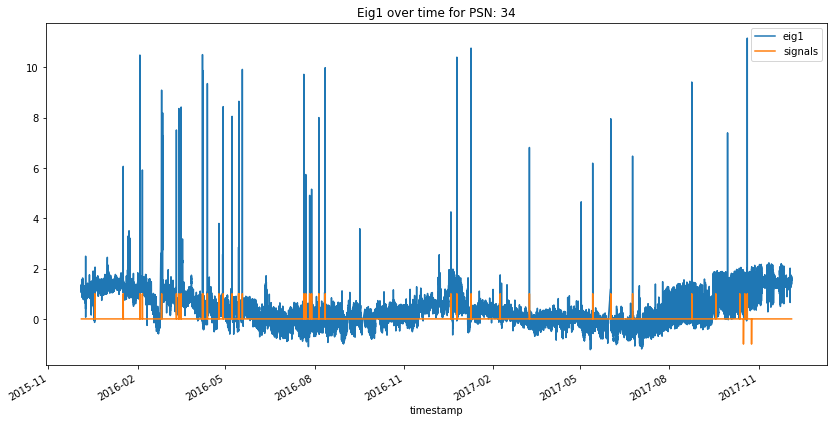

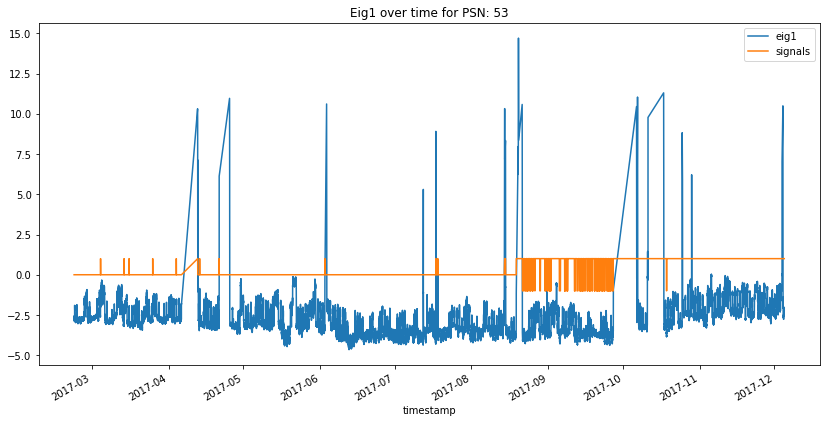

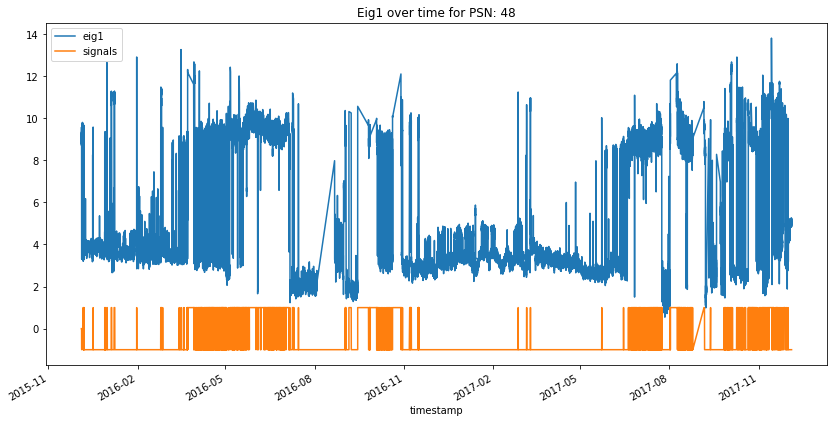

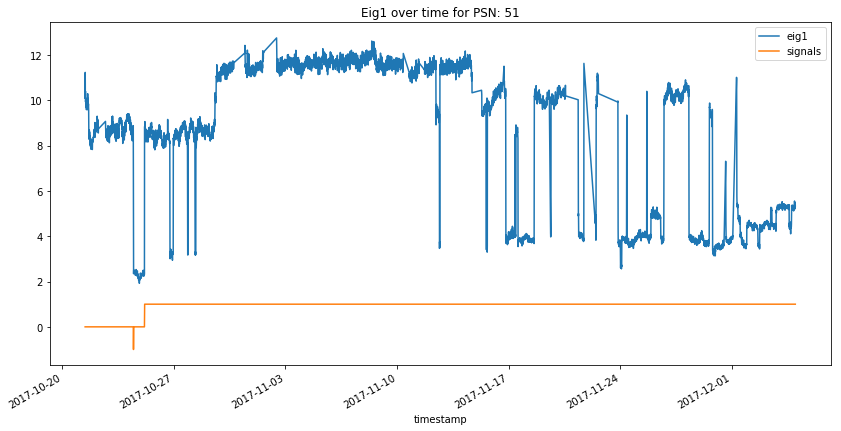

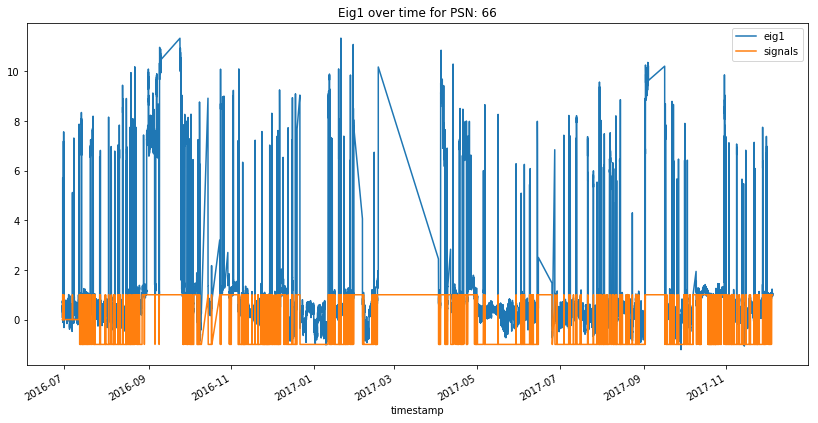

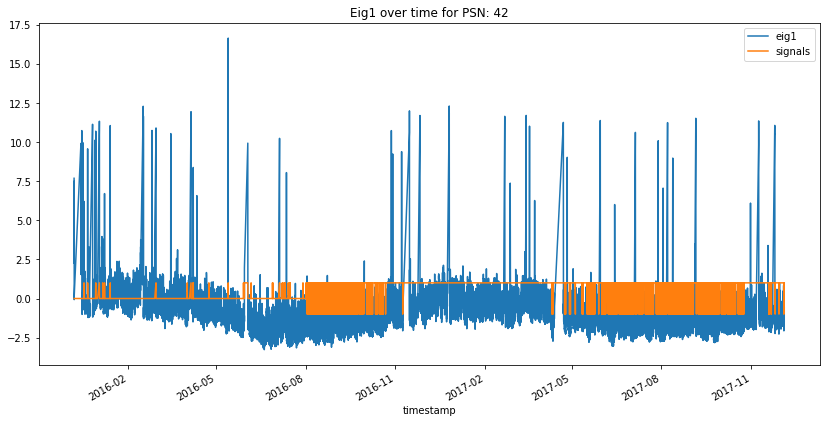

In [115]:
for psn in eig_df.psn.unique():
    temp_df = eig_df[eig_df.psn==psn]
    temp_signal_dict = thresholding_algo(temp_df.eig1.values)
    temp_df['signals'] = temp_signal_dict['signals']
    temp_df.plot(y=['eig1','signals'], x = 'timestamp')
    plt.title('Eig1 over time for PSN: '+str(psn))
    plt.show()


In [117]:
def find_power_step (df,powercol,jump = 0.25):
    ## function will return another dataframe where the power columns is replace with 1s and 0s. 1 represents an outlier.
    ## the returned dataframe is also offset by 1 index since we are finding differences in datapoints.
    ## assumes data coming in is sorted by psn by timestamp.

    
    df = df[[powercol,'timestamp','psn']]

    df = df.where((pd.notnull(df)),np.nan) ## replaces nulls with nans for math stuffs.
    df2 = pd.DataFrame(index = df.index.values[1:],columns = df.columns.values)
    df2['timestamp'] = df['timestamp'].values[1:]
    ## np.divide will divide the first parameter by the second parameter so the resulting series starts
    ## from the original dataframe's 1st item, not the 0th item.
#     shifted = pd.Series(np.subtract(df[powercol].values[1:],df[powercol].values[:-1]),index=df.index.values[:-1])

    shifted = pd.Series(np.divide(df[powercol].values[:-1],df[powercol].values[1:]),index=df.index.values[1:])-1

    ## take all values and subtract from previous values. if unchanging, then result will be 0
    ## create numpy array of all False

    tomap = np.zeros(len(df2),dtype=int)  
    
    
    ## find where jumps in data are greater than given jump parameter, and set numpy array equal to True in those positions
    for j in shifted[abs(shifted)>=jump].index.values:
        ## for now just doing where power jumps.
        ## does not catch all in betweens since transients are only 10-20 mins long.
        if (df.loc[j]['timestamp'] - df.loc[j-1]['timestamp']) > pd.Timedelta('12 minutes'): ## if data is not continuous
            continue
                        
        else:
            tomap[j] = True


    
    ## map back numpy array to df2
    df2[powercol] = pd.Series(tomap).loc[1:]

    df2.loc[0] = [0,df.loc[0]['timestamp'],0] ## assume not outlier for row 0. this also 0-indexes the dataframe again
    df2 = df2.sort_index()
    df2['psn'] = df['psn']
    return(df2)

In [130]:
find_power_step(eig_df,'eig1')

IndexError: index 1602695 is out of bounds for axis 0 with size 1602695

/Users/jillianjarrett/anaconda2/envs/py36envir/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


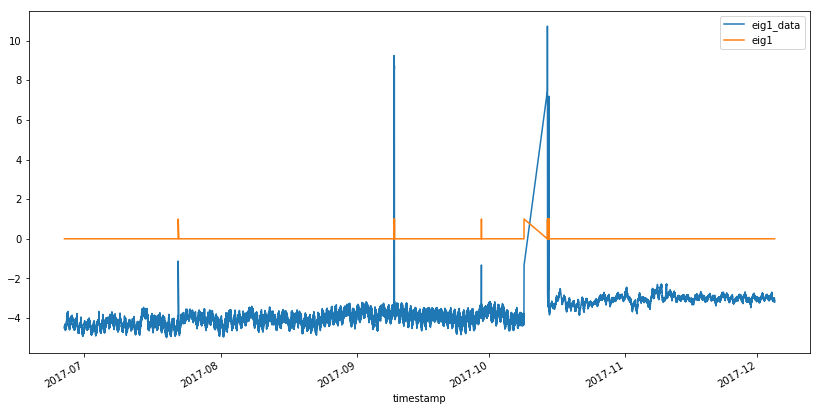

In [124]:
temp= find_power_step(psn39,'eig1')
temp['eig1_data']=psn39.eig1.values
temp.plot(x='timestamp',y=['eig1_data','eig1'])
plt.show()

In [144]:
def efficient_stepsize (inputdf,ignore_columns=None,threshold = 3):
    psns =  sorted(inputdf['psn'].unique())
    if ignore_columns == None:
        cols = inputdf.columns
    elif isinstance(ignore_columns,list):
        cols = [a for a in inputdf.columns if a not in list(ignore_columns)]
    else:
        raise Exception('ignore_columns must be list or None')
    no_timestamp_cols = [j for j in cols if j != 'timestamp']
    finaldf = pd.DataFrame(columns=inputdf.columns)

    for psn in psns:
#         print(psn)

        ## subset dataframe to just one psn
        onepackage = inputdf[inputdf['psn']==psn].sort_values(by='timestamp',ascending=True)
        
        ## subset to just columns we want to run stepsize on
        df = onepackage[cols]
        
        ## create datetimeindex
        df = df.reset_index()
        df = df.set_index(pd.DatetimeIndex(onepackage['timestamp']))
        
        # bin periods
        avgs = df.rolling('7d',min_periods=168).mean() ## 7days*24hrs=168 datapoints
        stdevs= df.rolling('7d',min_periods=168).std()
        
#         avgs = df.rolling('7d',closed='right').mean() ## 7days*24hrs=168 datapoints
#         stdevs= df.rolling('7d',closed='right').std()

        
        ## create low and high cutoffs
        highcutoff = avgs+threshold*stdevs
        lowcutoff = avgs-threshold*stdevs
        
        ## build return df
        highs = df > highcutoff ## True if above high cutoff
        lows = df < lowcutoff ## True if below high cutoff
        returndf = highs|lows
        
        ## put back the columns we ignored earlier with original values
        returndf['index'] = onepackage.index
        

        ## remove datetimeindex and re-set the original index
        returndf = returndf.reset_index().set_index('index')
#         returndf = returndf.drop('timestamp',axis=1).reset_index().set_index('index')

        
        for col in ignore_columns:
            returndf[col]=onepackage[col]

        
        ## append it to finaldf
        finaldf = finaldf.append(returndf)
    

    return(finaldf)

In [147]:
steps[steps.eig1==True]

eig1 index level_0 psn                  timestamp
1539   True   NaN   False  40 2017-08-23 08:09:59.999997
1540   True   NaN   False  40 2017-08-23 08:20:00.000002
1545   True   NaN   False  40 2017-08-23 09:10:00.000004
1572   True   NaN   False  40 2017-08-23 13:40:00.000004
1573   True   NaN   False  40 2017-08-23 13:49:59.999998
1574   True   NaN   False  40 2017-08-23 14:00:00.000003
1575   True   NaN   False  40 2017-08-23 14:09:59.999997
1576   True   NaN   False  40 2017-08-23 14:20:00.000002
1577   True   NaN   False  40 2017-08-23 14:29:59.999996
1578   True   NaN   False  40 2017-08-23 14:40:00.000001
1579   True   NaN   False  40 2017-08-23 14:49:59.999995
1580   True   NaN   False  40 2017-08-23 15:00:00.000000
1581   True   NaN   False  40 2017-08-23 15:10:00.000004
1582   True   NaN   False  40 2017-08-23 15:19:59.999998
1583   True   NaN   False  40 2017-08-23 15:30:00.000003
1584   True   NaN   False  40 2017-08-23 15:39:59.999997
1585   True   NaN   False  40 2017-08-23 15:50:00.000002
1586   True   NaN   False  40 2017-08-23 15:59:59.999996
1587   True   NaN   False  40 2017-08-23 16:10:00.000001
1588   True   NaN   False  40 2017-08-23 16:19:59.999995
1589   True   NaN   False  40 2017-08-23 16:30:00.000000
1590   True   NaN   False  40 2017-08-23 16:40:00.000004
1619   True   NaN   False  40 2017-08-23 21:30:00.000003
1620   True   NaN   False  40 2017-08-23 21:39:59.999997
1621   True   NaN   False  40 2017-08-23 21:50:00.000002
1622   True   NaN   False  40 2017-08-23 21:59:59.999996
1623   True   NaN   False  40 2017-08-23 22:10:00.000001
1624   True   NaN   False  40 2017-08-23 22:19:59.999995
1625   True   NaN   False  40 2017-08-23 22:30:00.000000
1626   True   NaN   False  40 2017-08-23 22:40:00.000004
...     ...   ...     ...  ..                        ...
12365  True   NaN   False  40 2017-11-10 00:39:59.999997
12366  True   NaN   False  40 2017-11-10 00:50:00.000002
12367  True   NaN   False  40 2017-11-10 00:59:59.999996
12368  True   NaN   False  40 2017-11-10 01:10:00.000001
12369  True   NaN   False  40 2017-11-10 01:19:59.999995
12370  True   NaN   False  40 2017-11-10 01:30:00.000000
12371  True   NaN   False  40 2017-11-10 01:40:00.000004
12372  True   NaN   False  40 2017-11-10 01:49:59.999998
12373  True   NaN   False  40 2017-11-10 02:00:00.000003
12374  True   NaN   False  40 2017-11-10 02:09:59.999997
12375  True   NaN   False  40 2017-11-10 02:20:00.000002
12376  True   NaN   False  40 2017-11-10 02:29:59.999996
12940  True   NaN   False  40 2017-11-14 00:30:00.000003
13194  True   NaN   False  40 2017-11-29 05:00:00.000003
13195  True   NaN   False  40 2017-11-29 05:09:59.999997
13196  True   NaN   False  40 2017-11-29 05:20:00.000002
13197  True   NaN   False  40 2017-11-29 05:29:59.999996
13198  True   NaN   False  40 2017-11-29 05:40:00.000001
13199  True   NaN   False  40 2017-11-29 05:49:59.999995
13200  True   NaN   False  40 2017-11-29 06:00:00.000000
13201  True   NaN   False  40 2017-11-29 06:10:00.000004
13202  True   NaN   False  40 2017-11-29 06:19:59.999998
13203  True   NaN   False  40 2017-11-29 06:30:00.000003
13204  True   NaN   False  40 2017-11-29 06:39:59.999997
13205  True   NaN   False  40 2017-11-29 06:50:00.000002
13206  True   NaN   False  40 2017-11-29 06:59:59.999996
13207  True   NaN   False  40 2017-11-29 07:10:00.000001
13208  True   NaN   False  40 2017-11-29 07:19:59.999995
13209  True   NaN   False  40 2017-11-29 07:30:00.000000
13210  True   NaN   False  40 2017-11-29 07:40:00.000004

[347 rows x 5 columns]

In [148]:
jumps_df.head()

eig1                  timestamp  psn  eig1_data stepsize_fn
0   0.0 2017-08-12 04:30:00.000000   40   8.282554       False
1   0.0 2017-08-12 04:40:00.000004   40   8.434760       False
2   0.0 2017-08-12 04:49:59.999998   40   8.394499       False
3   0.0 2017-08-12 05:00:00.000003   40   8.299895       False
4   0.0 2017-08-12 05:09:59.999997   40   8.452723       False

/Users/jillianjarrett/anaconda2/envs/py36envir/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


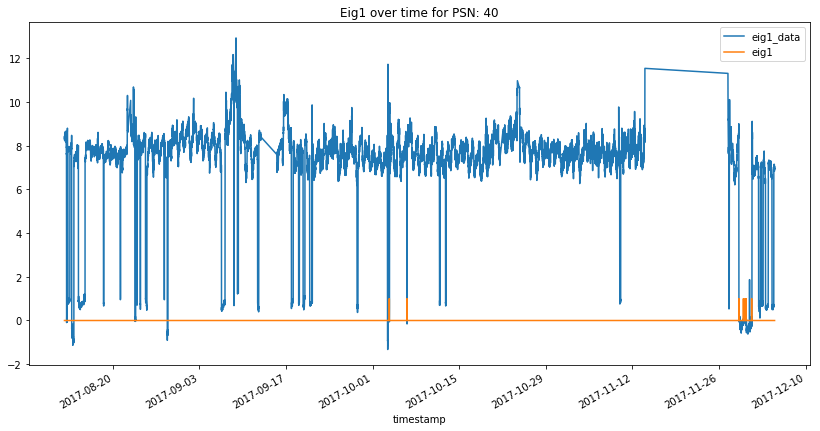

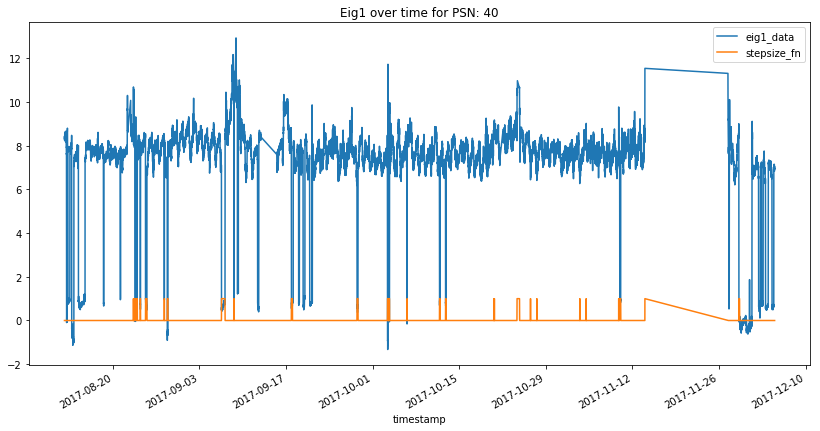

In [152]:
psn=40
temp_df = eig_df[eig_df.psn==psn].reset_index()
#tep_df.reset_index()
jumps_df = find_power_step(temp_df,'eig1', jump=50)
jumps_df['eig1_data']=temp_df.eig1.values
steps = efficient_stepsize(temp_df,ignore_columns=['timestamp','psn']) 
jumps_df['stepsize_fn']= [int(x) for x in steps.eig1.values]
jumps_df.plot(x='timestamp',y=['eig1_data','eig1'])
plt.title('Eig1 over time for PSN: '+str(psn))
plt.show()
jumps_df.plot(x='timestamp',y=['eig1_data','stepsize_fn'])
plt.title('Eig1 over time for PSN: '+str(psn))
plt.show()

/Users/jillianjarrett/anaconda2/envs/py36envir/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


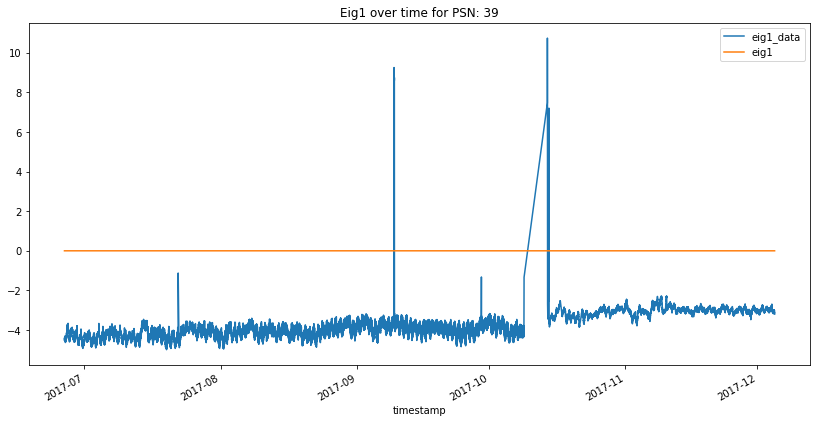

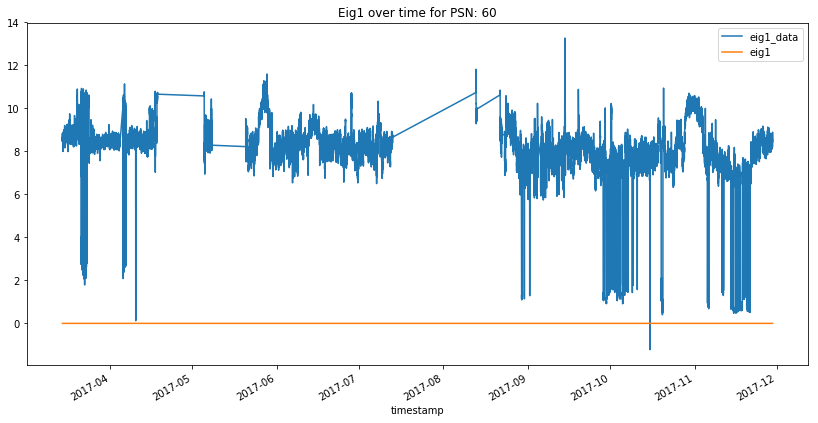

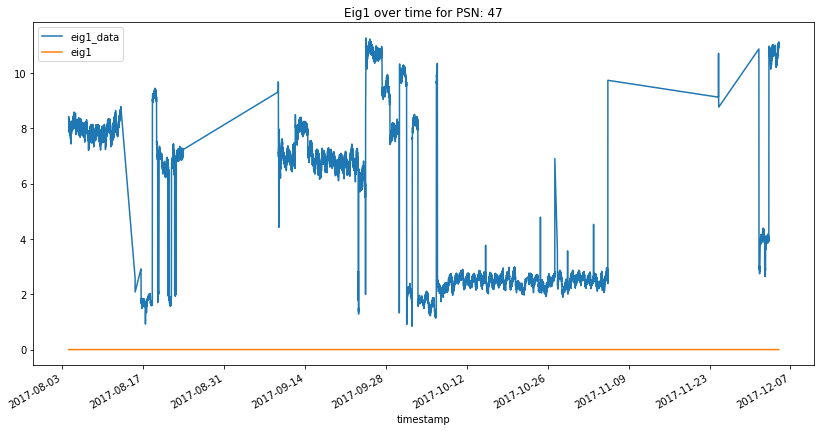

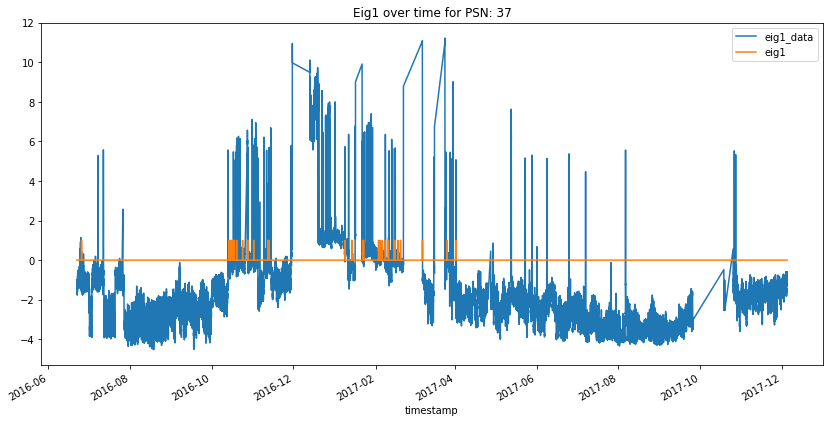

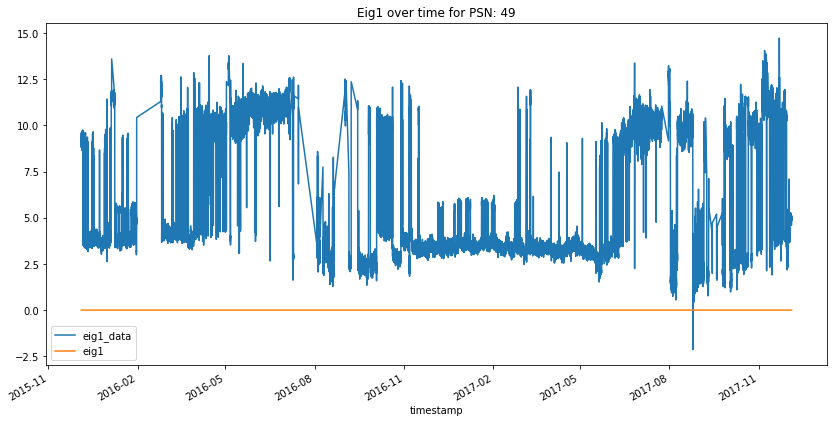

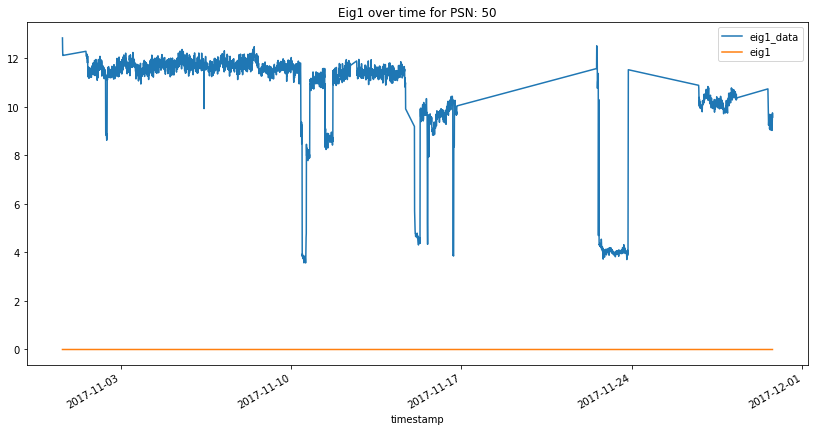

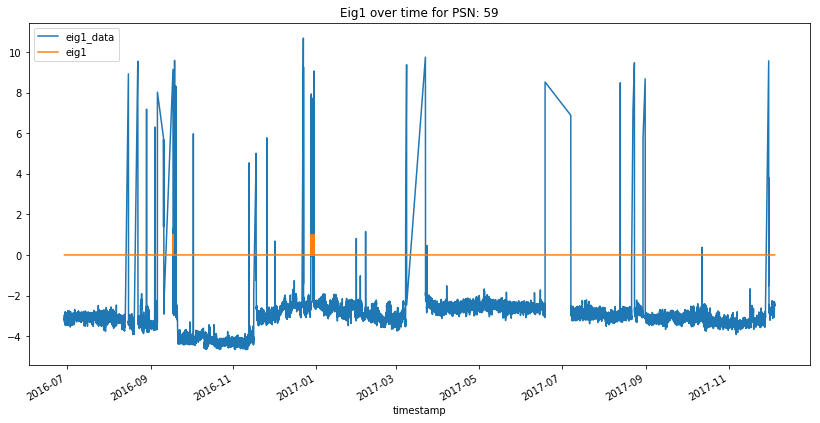

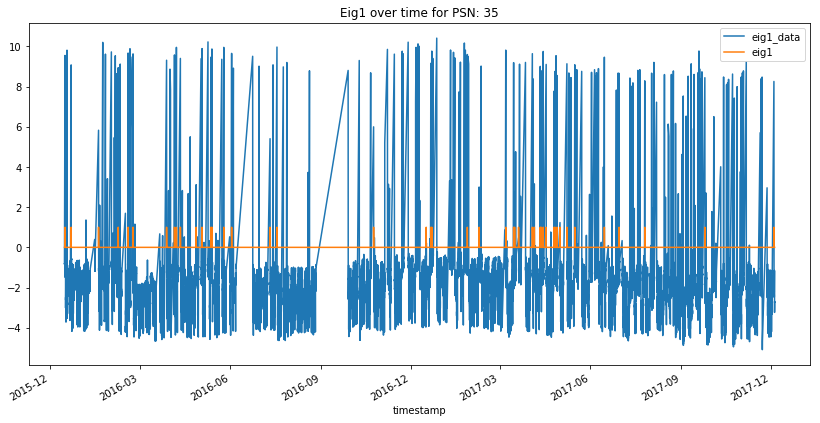

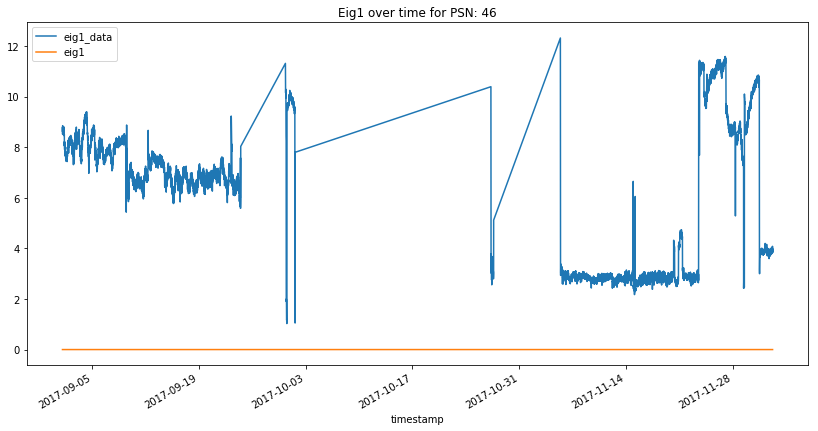

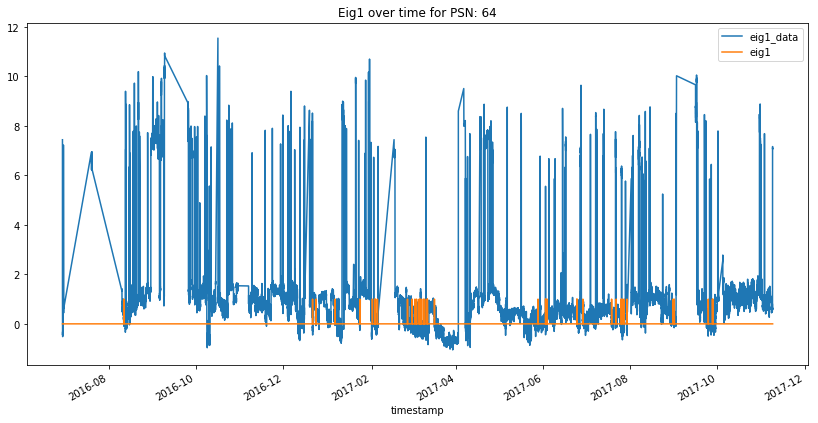

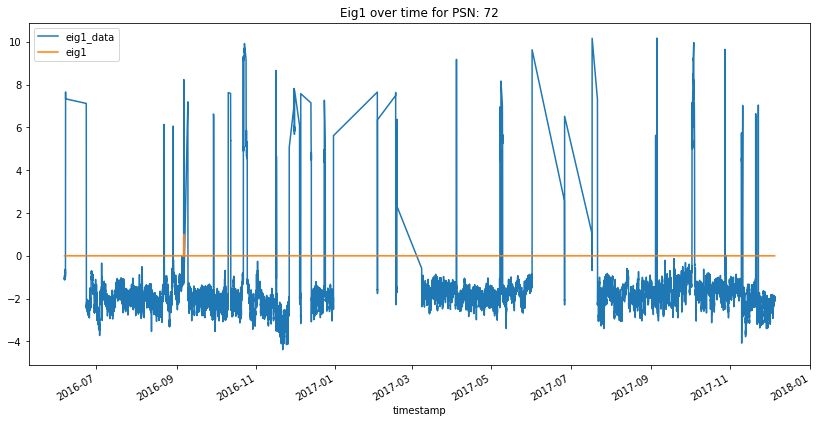

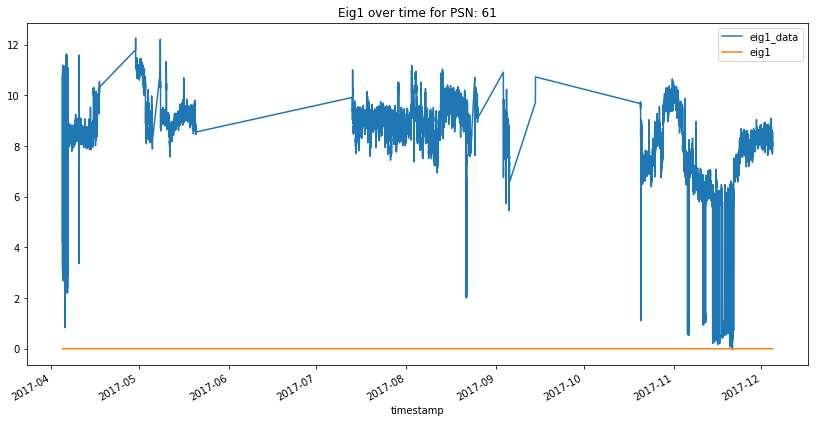

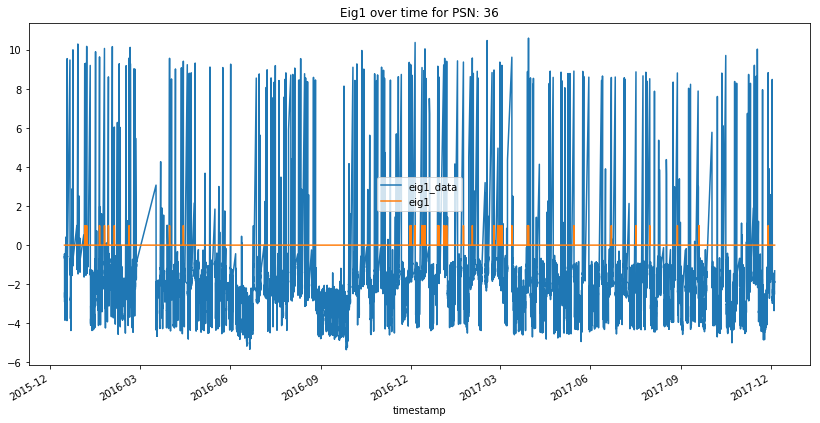

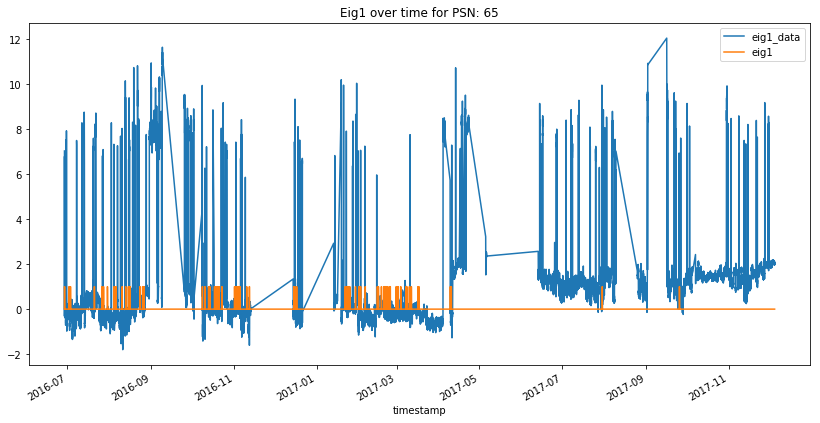

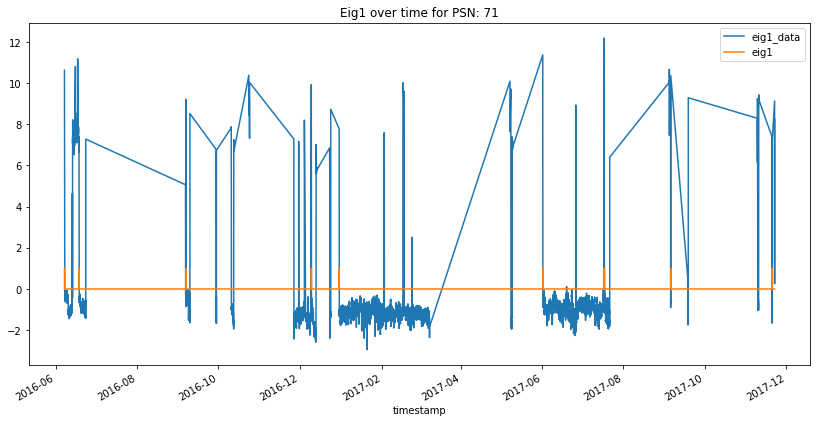

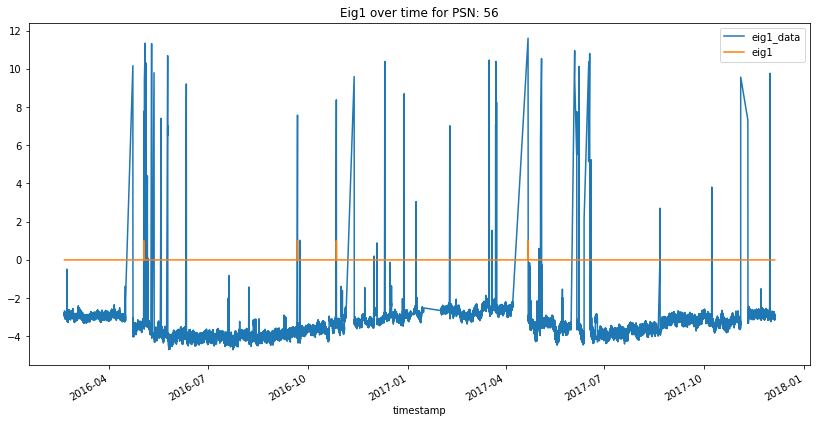

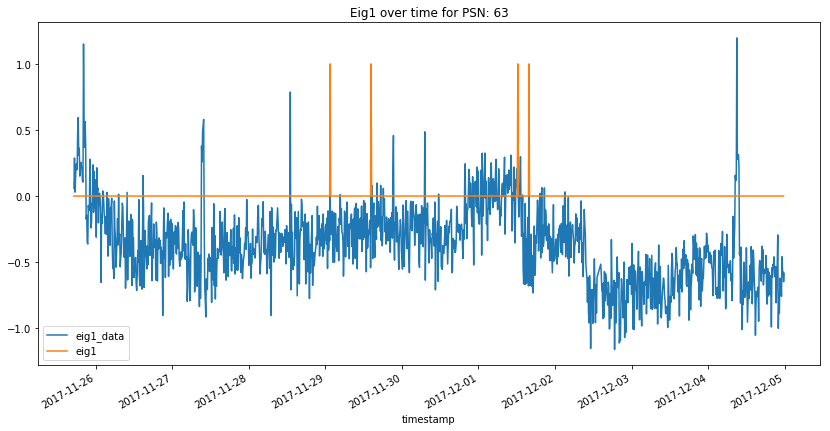

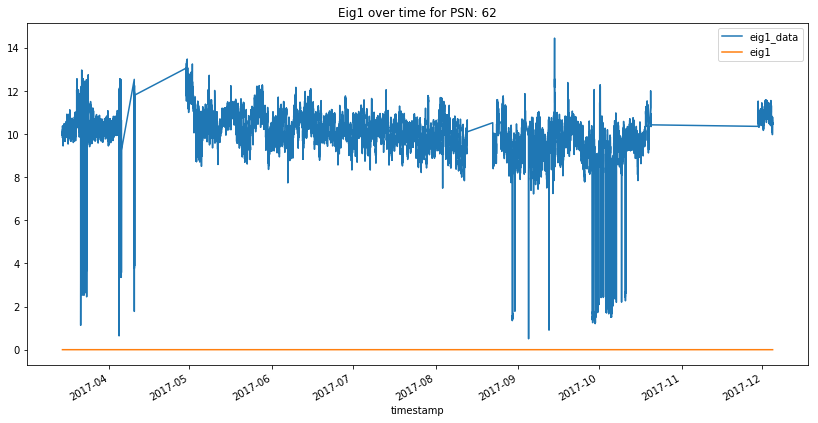

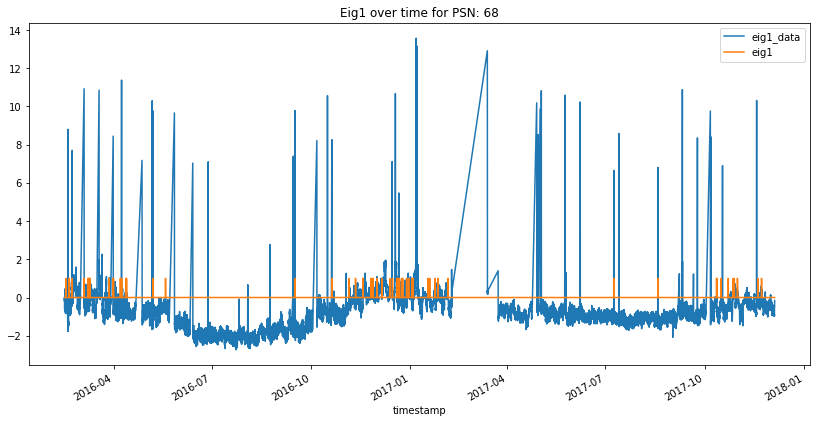

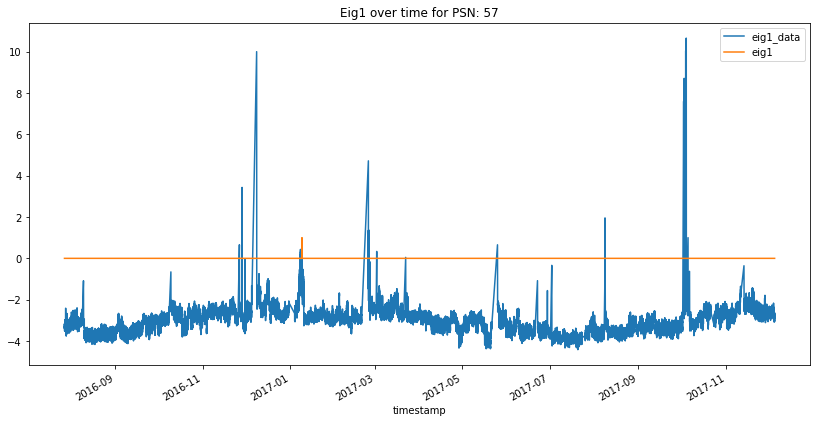

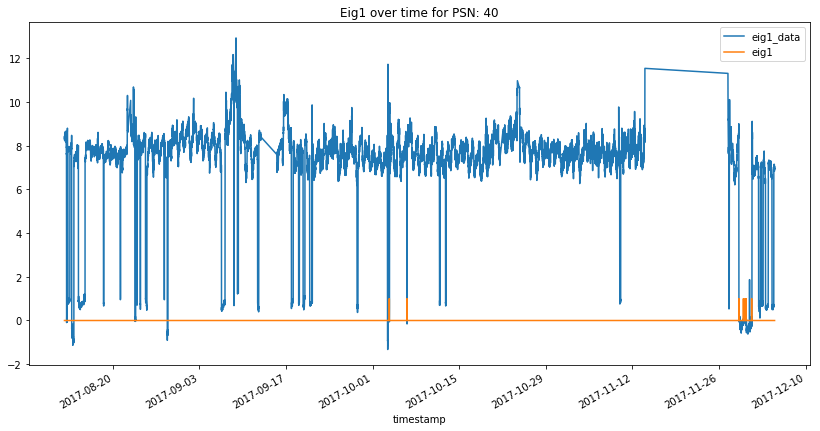

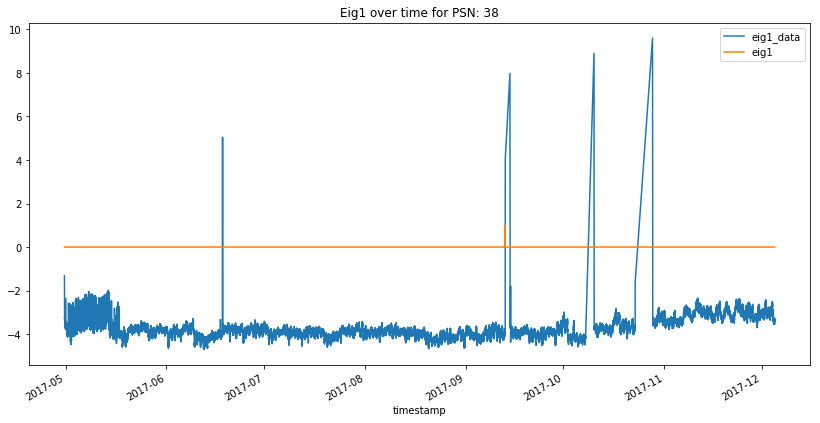

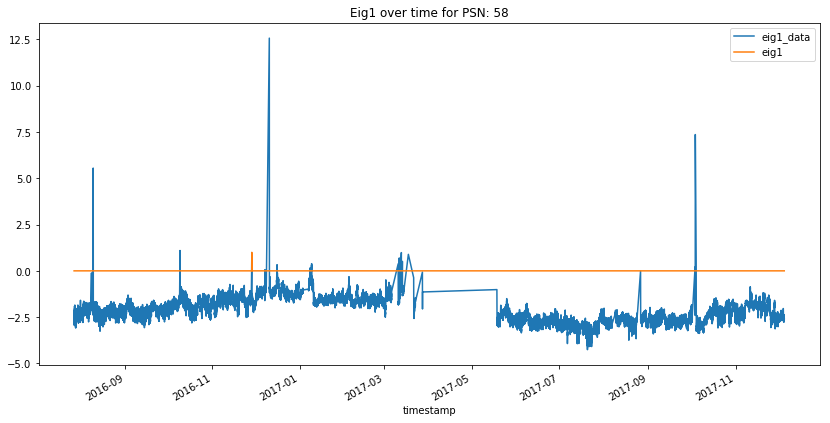

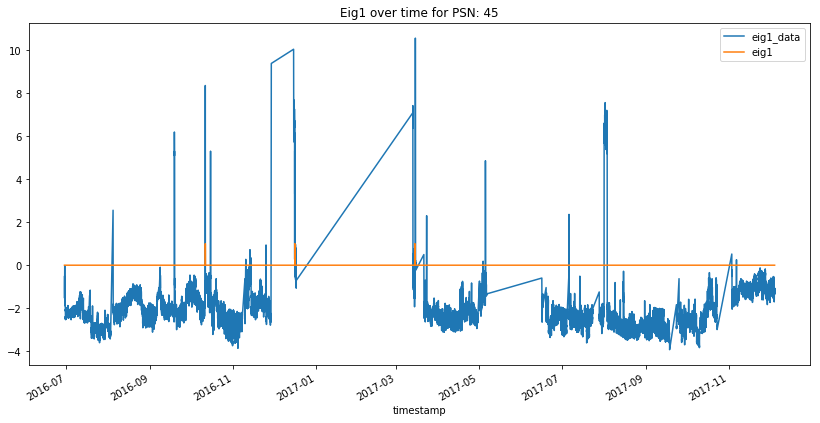

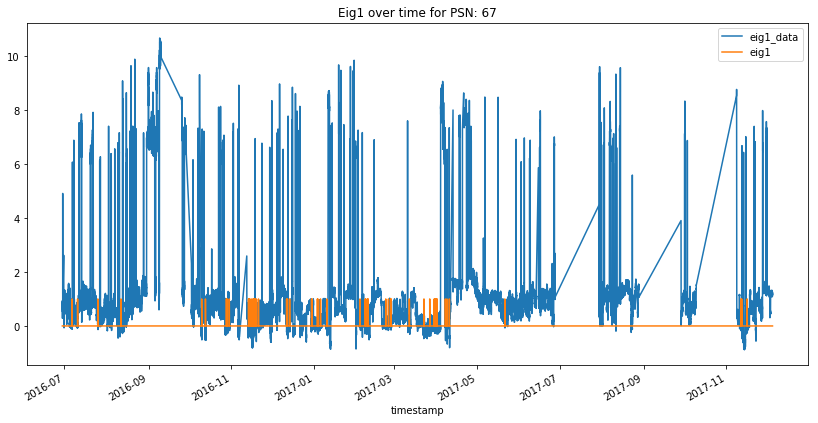

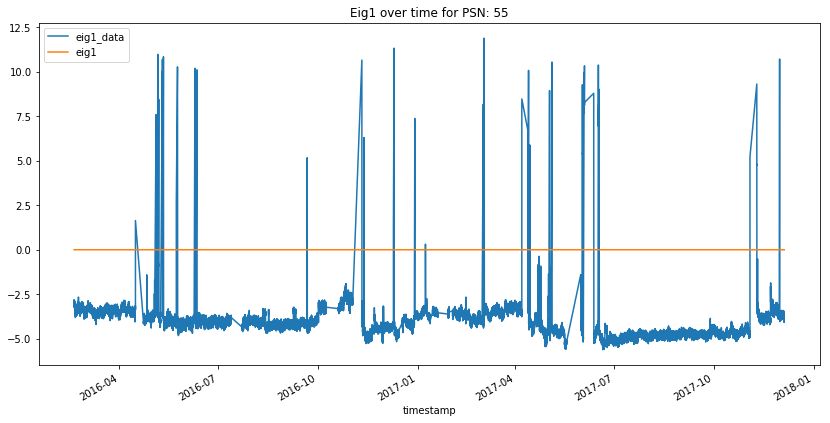

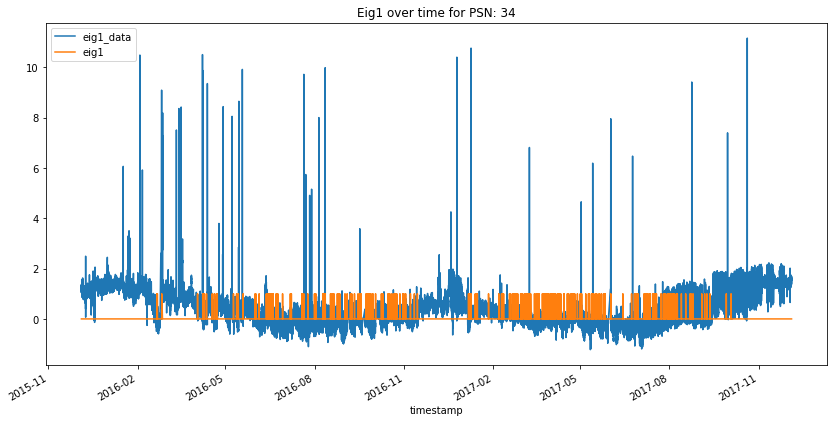

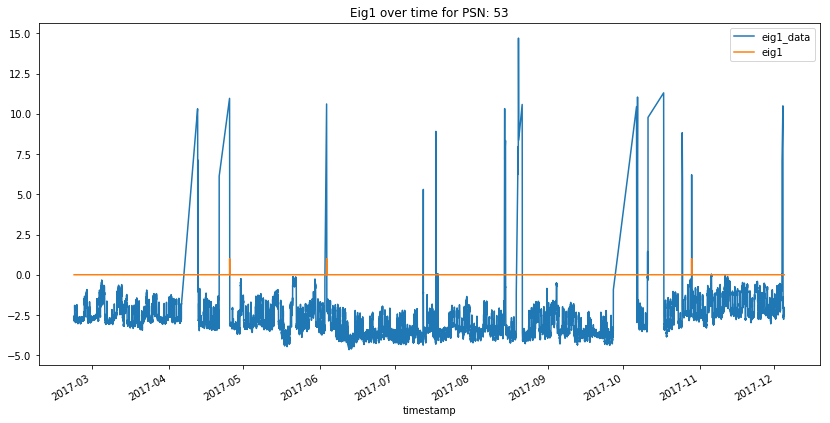

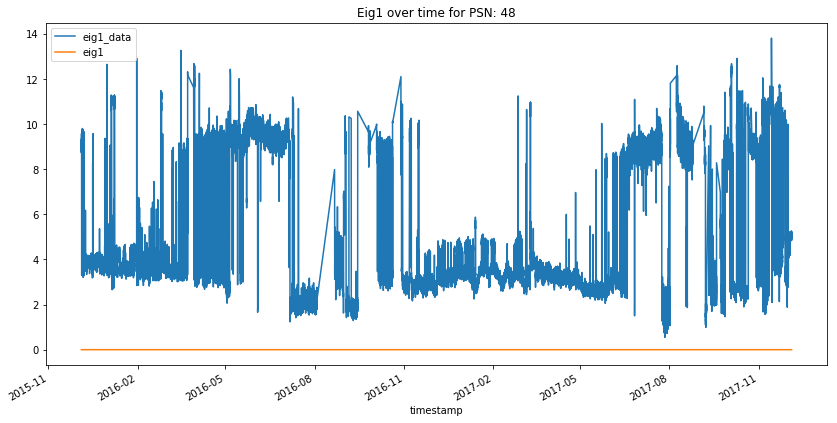

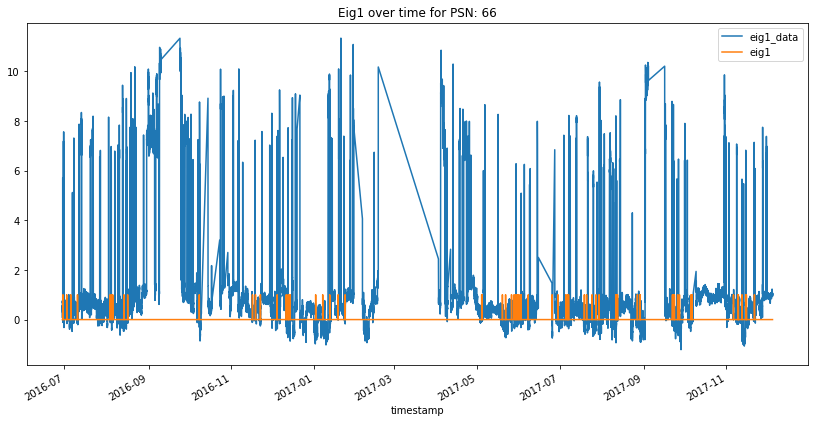

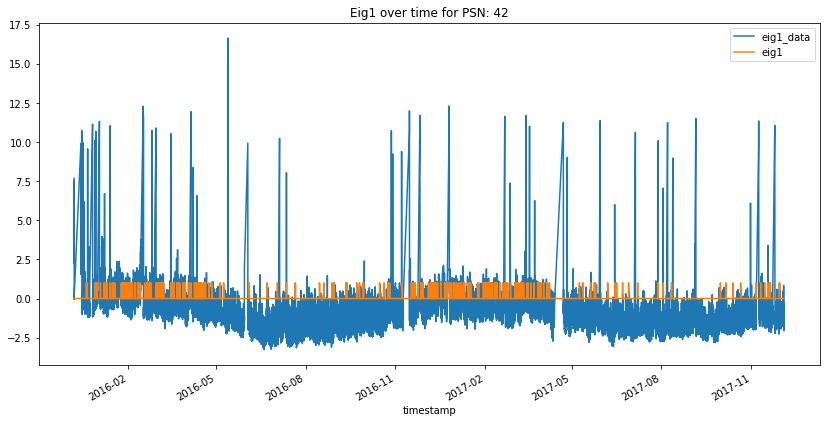

In [140]:
for psn in eig_df.psn.unique():
    temp_df = eig_df[eig_df.psn==psn].reset_index()
    steps_df = find_power_step(temp_df,'eig1', jump=50)
    steps_df['eig1_data']=temp_df.eig1.values
    steps_df .plot(x='timestamp',y=['eig1_data','eig1'])
    plt.title('Eig1 over time for PSN: '+str(psn))
    plt.show()


